In [ ]:
pip install optuna


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import QuantileTransformer,MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.svm import  SVC
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import accuracy_score as accuracy
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier,BaggingClassifier,StackingClassifier
from abc import ABC,abstractmethod



import warnings
warnings.filterwarnings("ignore")


**Project Pipline**





1.   Import data
1.   Problem determination
3.   Exploratory data analysis
2.   Feature Engineering
2.   Model Building
1.   Prediction for submission







---
**1.Import Data**

---

In [ ]:
df = pd.read_csv('/content/wine.csv')
submission_df = pd.read_csv('/content/wine_predict.csv')

df.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.8,0.18,0.31,12.2,0.053,46.0,140.0,0.9980,3.06,0.53,8.9,3
1,7.3,0.51,0.26,3.3,0.090,7.0,135.0,0.9944,3.01,0.52,8.8,2


---
**2. Problem determination**


---



In [ ]:
df['quality'].unique()

array([3, 2, 4, 1, 5])

**Summary:** target features has more that 2 categories,so we are dealing with multiclass classification probmens, so we will use OVO,OVA strategies for base estimators.



---


**3.Exploratory data analysis**


---



Generall outlook

In [ ]:
df_copy = df

In [ ]:
df_copy['quality'] = df_copy['quality'].astype(str)

In [ ]:
df_copy.shape

(3518, 12)

In [ ]:
df_copy.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [ ]:
df_copy.dtypes

,0
fixed acidity,float64
volatile acidity,float64
citric acid,float64
residual sugar,float64
chlorides,float64
free sulfur dioxide,float64
total sulfur dioxide,float64
density,float64
pH,float64
sulphates,float64


In [ ]:
df_copy.isna().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [ ]:
df_copy[df_copy.duplicated() == True]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


Relations between features and target variable

In [ ]:
numerical_features = df_copy.select_dtypes(include = ['int64','float64']).columns.to_list()

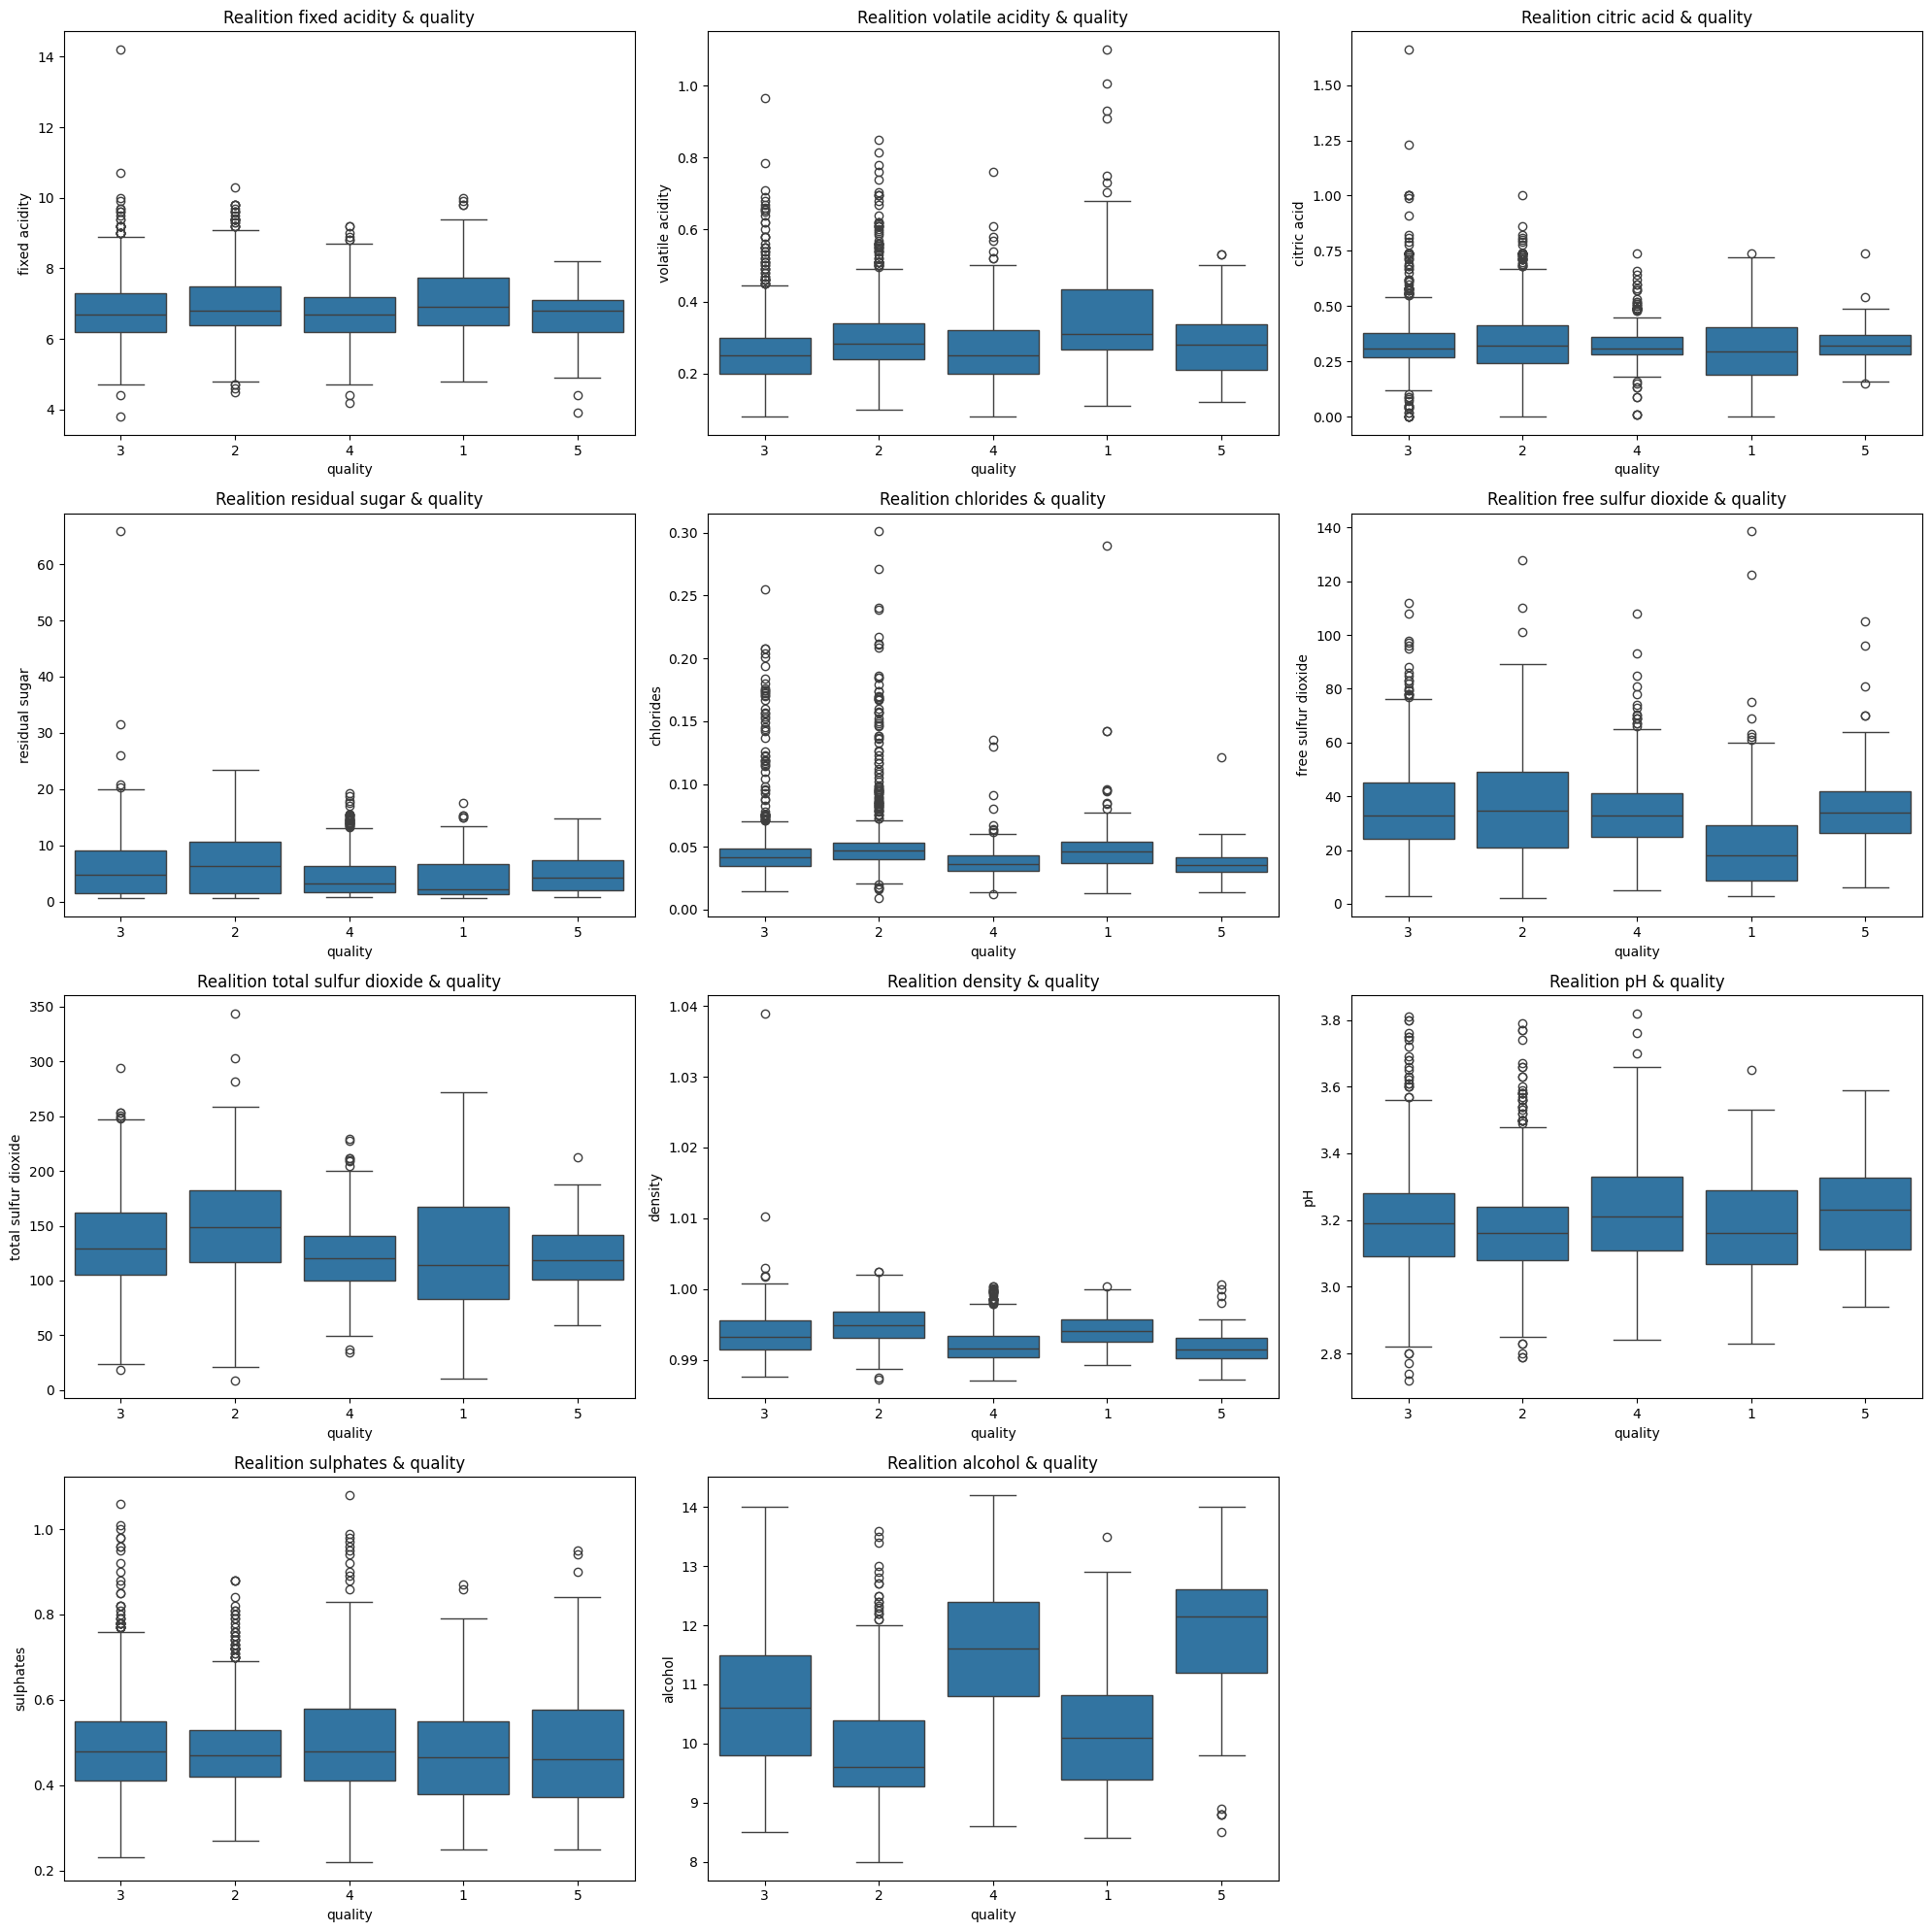

In [ ]:
fig = plt.figure(figsize = (20,20))

for feature_idx,feature in enumerate(numerical_features):
  plt.subplot(4,3,feature_idx + 1)
  sns.boxplot(data = df_copy,y = feature,x = 'quality')
  plt.title(f'Realition {feature} & quality')

plt.tight_layout()
plt.show()


<Axes: xlabel='quality', ylabel='count'>

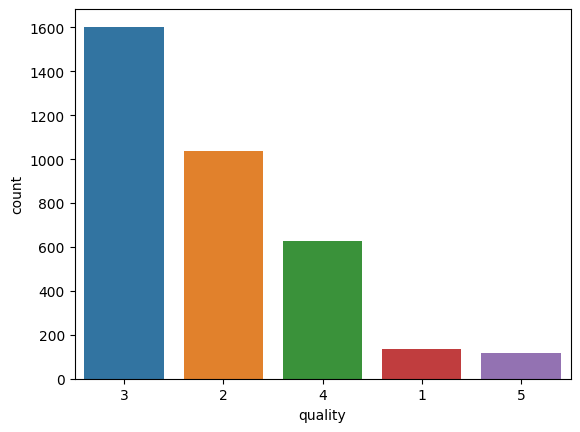

In [ ]:
sns.countplot(data = df_copy,x = 'quality',hue = 'quality')

**Summary:** sulphates,citric_acidity literally has no variace how is might be deleted and we have imbalance in target feature,so we have to deal with it



---


**4.Feature Engineering**


*   Preventing Data Leakage
*   Outliers Treatment
*   Feature Scaling
*   Feature selection
*   Target imbalance treatment

---








Preventing Data Lakage

In [ ]:
df = df.rename(columns = {'fixed acidity': 'fixed_acidity',
                     'volatile acidity': 'volatile_acidity',
                     'citric acid': 'citric_acid',
                     'residual sugar': 'residual_sugar',
                     'free sulfur dioxide':'free_sulfur_dioxide',
                     'total sulfur dioxide': 'total_sulfur_dioxide'})

submission_df = submission_df.rename(columns = {'fixed acidity': 'fixed_acidity',
                     'volatile acidity': 'volatile_acidity',
                     'citric acid': 'citric_acid',
                     'residual sugar': 'residual_sugar',
                     'free sulfur dioxide':'free_sulfur_dioxide',
                     'total sulfur dioxide': 'total_sulfur_dioxide'})

In [ ]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(df,test_size = 0.2,random_state = 42)
train_df.shape,test_df.shape

((2814, 12), (704, 12))

Outliers Treatment

*   Univariative outliers
*   Bivariative outliers



Univariative outliers

In [ ]:
features = [column for column in train_df.columns if column != 'quality']

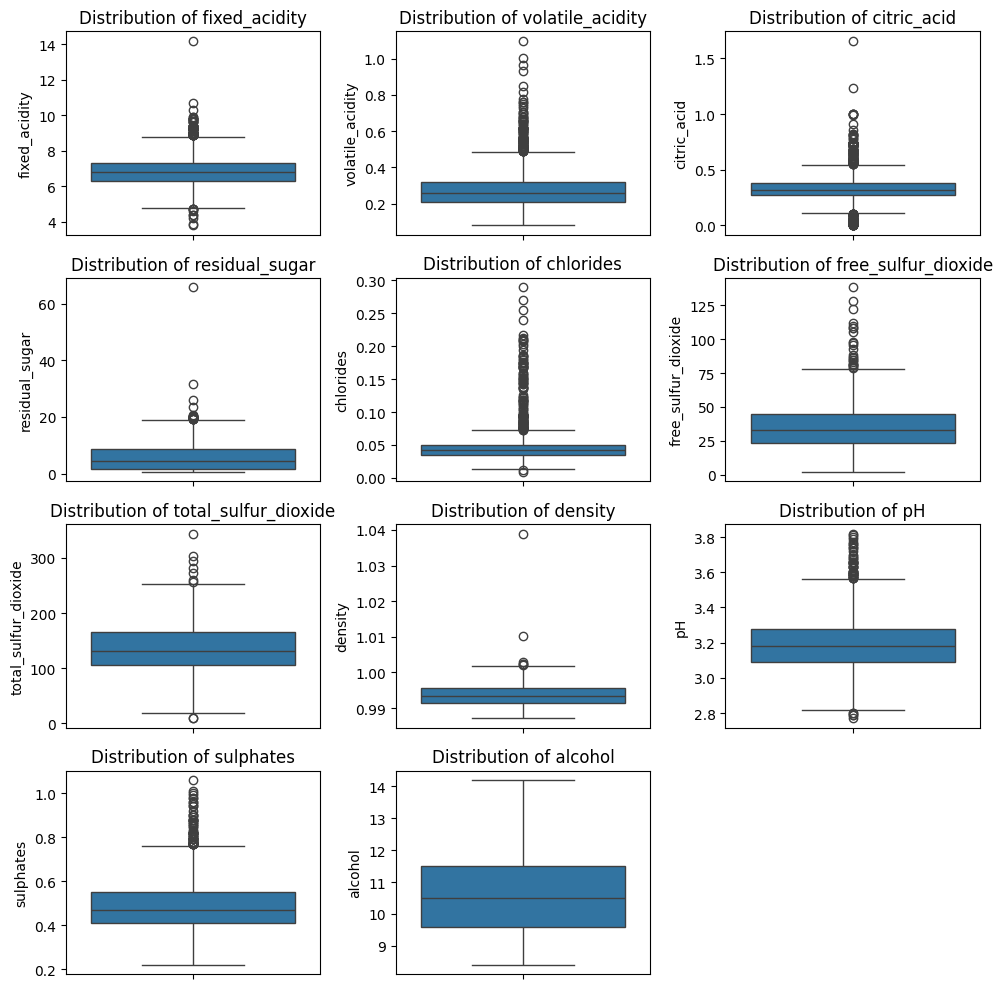

In [ ]:
fig = plt.figure(figsize = (10,10))

for feature_idx,feature in enumerate(features):
  plt.subplot(4,3,feature_idx + 1)
  sns.boxplot(data = train_df,y = feature)
  plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [ ]:
total_outliers = 0

def detect_outliers(feature):
  Q1 = train_df[feature].quantile(0.25)
  Q3 = train_df[feature].quantile(0.75)
  IQR = Q3 - Q1

  upper_treshold = Q3 + 1.5 * IQR
  lower_treshold = Q1 - 1.5 * IQR

  outliers = train_df.query(f'{feature} < {lower_treshold} or {feature} > {upper_treshold}')
  outliers_count = len(train_df.query(f'{feature} < {lower_treshold} or {feature} > {upper_treshold}').index)
  outliers_percent = (outliers_count * 100) / train_df.shape[0]


  print(f'Outliers in {feature}: {round(outliers_percent,2)}%')
  return outliers_count

In [ ]:
total_outliers = 0
for feature in features:
  total_outliers += detect_outliers(feature)

print(f'\nTotal outliers: {round((total_outliers * 100) / train_df.shape[0],2)}%')

Outliers in fixed_acidity: 2.59%
Outliers in volatile_acidity: 4.05%
Outliers in citric_acid: 6.65%
Outliers in residual_sugar: 0.78%
Outliers in chlorides: 4.58%
Outliers in free_sulfur_dioxide: 0.85%
Outliers in total_sulfur_dioxide: 0.32%
Outliers in density: 0.21%
Outliers in pH: 1.81%
Outliers in sulphates: 2.38%
Outliers in alcohol: 0.0%

Total outliers: 24.24%


In [ ]:
def remove_outliers(feature):
  Q1 = train_df[feature].quantile(0.25)
  Q3 = train_df[feature].quantile(0.75)
  IQR = Q3 - Q1

  upper_treshold = Q3 + 1.5 * IQR
  lower_treshold = Q1 - 1.5 * IQR

  train_df[feature] = train_df[feature].apply(lambda x: lower_treshold if x < lower_treshold else x)
  train_df[feature] = train_df[feature].apply(lambda x: upper_treshold if x > upper_treshold else x)

In [ ]:
for feature in features:
  remove_outliers(feature)

Bivariative outliers

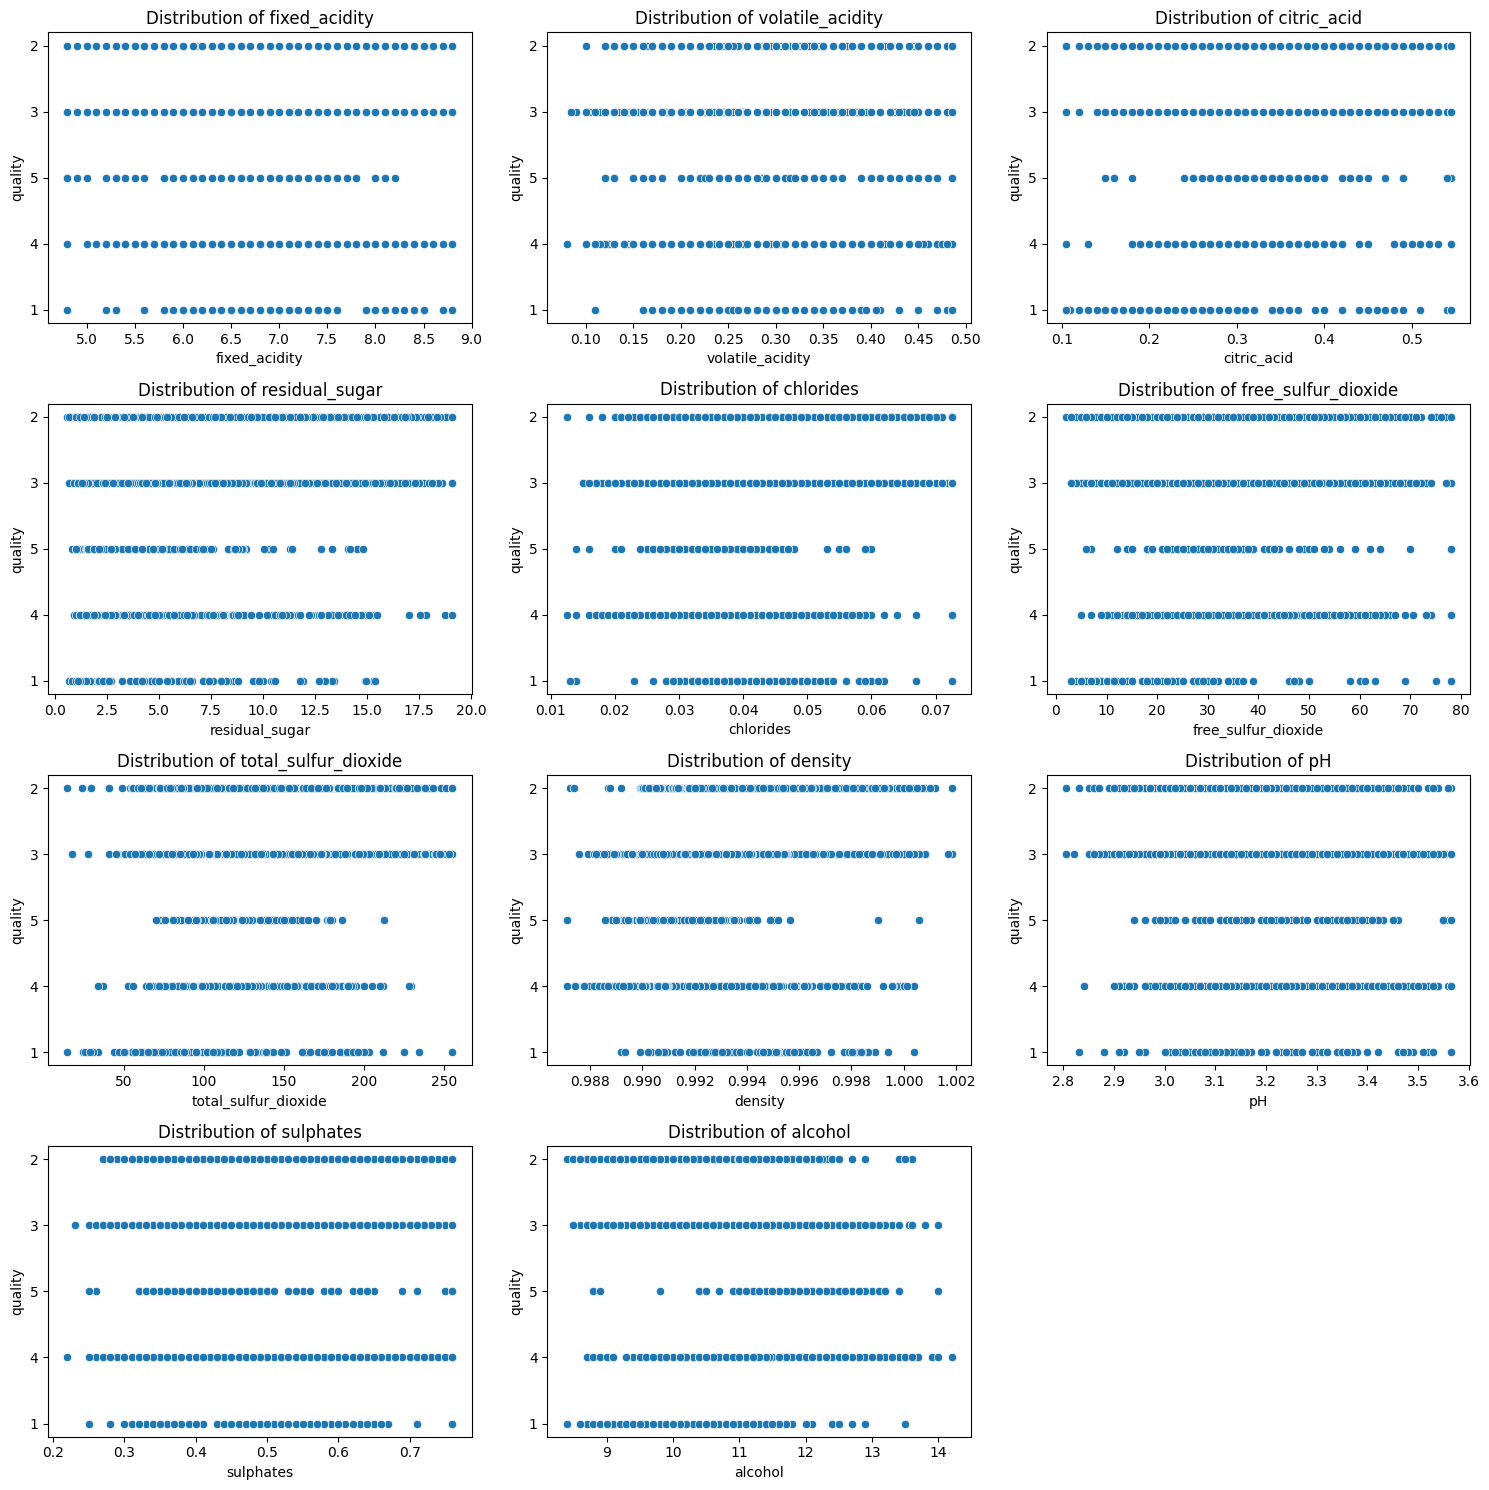

In [ ]:
fig = plt.figure(figsize = (15,15))

for feature_idx,feature in enumerate(features):
  plt.subplot(4,3,feature_idx + 1)
  sns.scatterplot(data = train_df,x = feature,y = 'quality')
  plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [ ]:
# remove outliers from fixed_acidity
values_to_drop = train_df.query('fixed_acidity < 5 and quality == "4"').index.to_list()
values_to_drop += train_df.query('fixed_acidity < 5.5 and quality == "1"').index.to_list()

# remove outliers from volatile_acidity
values_to_drop += train_df.query('volatile_acidity < 0.15 and quality == "1"').index.to_list()
values_to_drop += train_df.query('volatile_acidity < 0.10 and quality == "4"').index.to_list()
values_to_drop += train_df.query('volatile_acidity < 0.12 and quality == "2"').index.to_list()

# remove outliers from citric_acid
values_to_drop += train_df.query('citric_acid > 0.5 and quality == "1"').index.to_list()
values_to_drop += train_df.query('citric_acid < 0.15 and quality == "4"').index.to_list()
values_to_drop += train_df.query('citric_acid < 0.2 and quality == "5"').index.to_list()
values_to_drop += train_df.query('citric_acid > 0.53 and quality == "5"').index.to_list()
values_to_drop += train_df.query('citric_acid < 0.13 and quality == "3"').index.to_list()

# remove outliers from residual_sugar
values_to_drop += train_df.query('residual_sugar > 11 and quality == "1"').index.to_list()
values_to_drop += train_df.query('residual_sugar > 16 and quality == "4"').index.to_list()
values_to_drop += train_df.query('residual_sugar > 12 and quality == "5"').index.to_list()

# remove outliers from chlorides
values_to_drop += train_df.query('chlorides < 0.025 and quality == "1"').index.to_list()
values_to_drop += train_df.query('chlorides > 0.066 and quality == "1"').index.to_list()
values_to_drop += train_df.query('chlorides > 0.06 and quality == "4"').index.to_list()
values_to_drop += train_df.query('chlorides < 0.024 and quality == "5"').index.to_list()
values_to_drop += train_df.query('chlorides > 0.055 and quality == "5"').index.to_list()

# remove outliers from free_sulfur_dioxide
values_to_drop += train_df.query('free_sulfur_dioxide > 65 and quality == "1"').index.to_list()
values_to_drop += train_df.query('free_sulfur_dioxide > 69 and quality == "4"').index.to_list()
values_to_drop += train_df.query('free_sulfur_dioxide > 65 and quality == "5"').index.to_list()

# remove outliers from total_sulfur_dioxide
values_to_drop += train_df.query('total_sulfur_dioxide > 210 and quality == "1"').index.to_list()
values_to_drop += train_df.query('total_sulfur_dioxide < 50 and quality == "4"').index.to_list()
values_to_drop += train_df.query('total_sulfur_dioxide > 226 and quality == "4"').index.to_list()
values_to_drop += train_df.query('total_sulfur_dioxide > 200 and quality == "5"').index.to_list()
values_to_drop += train_df.query('total_sulfur_dioxide < 40 and quality == "3"').index.to_list()
values_to_drop += train_df.query('total_sulfur_dioxide < 30 and quality == "2"').index.to_list()

# remove outliers from density
values_to_drop += train_df.query('density > 0.999 and quality == "1"').index.to_list()
values_to_drop += train_df.query('density < 0.990 and quality == "1"').index.to_list()
values_to_drop += train_df.query('density > 0.998 and quality == "5"').index.to_list()
values_to_drop += train_df.query('density < 0.988 and quality == "5"').index.to_list()
values_to_drop += train_df.query('density > 1.001 and quality == "3"').index.to_list()
values_to_drop += train_df.query('density < 0.989 and quality == "2"').index.to_list()

# remove outliers from pH
values_to_drop += train_df.query('pH < 2.95 and quality == "1"').index.to_list()
values_to_drop += train_df.query('pH < 2.9 and quality == "4"').index.to_list()
values_to_drop += train_df.query('pH > 3.5 and quality == "5"').index.to_list()
values_to_drop += train_df.query('pH < 2.85 and quality == "3"').index.to_list()

# remove outliers from sulphates
values_to_drop += train_df.query('sulphates > 0.7 and quality == "1"').index.to_list()
values_to_drop += train_df.query('sulphates < 0.3 and quality == "1"').index.to_list()
values_to_drop += train_df.query('sulphates < 0.25 and quality == "4"').index.to_list()
values_to_drop += train_df.query('sulphates < 0.3 and quality == "5"').index.to_list()
values_to_drop += train_df.query('sulphates > 0.65 and quality == "5"').index.to_list()
values_to_drop += train_df.query('sulphates < 0.24 and quality == "3"').index.to_list()

# remove outliers from alcohol
values_to_drop += train_df.query('alcohol > 12 and quality == "1"').index.to_list()
values_to_drop += train_df.query('alcohol > 13.9 and quality == "4"').index.to_list()
values_to_drop += train_df.query('alcohol < 10 and quality == "5"').index.to_list()
values_to_drop += train_df.query('alcohol > 13.7 and quality == "5"').index.to_list()
values_to_drop += train_df.query('alcohol > 12.5 and quality == "2"').index.to_list()

In [ ]:
train_df.drop(list(set(values_to_drop)),axis = 0,inplace = True)
print(f'Removed {round((len(list(set(values_to_drop))) * 100) / train_df.shape[0],1)}% of data')

Removed 6.1% of data


Feature Scaling

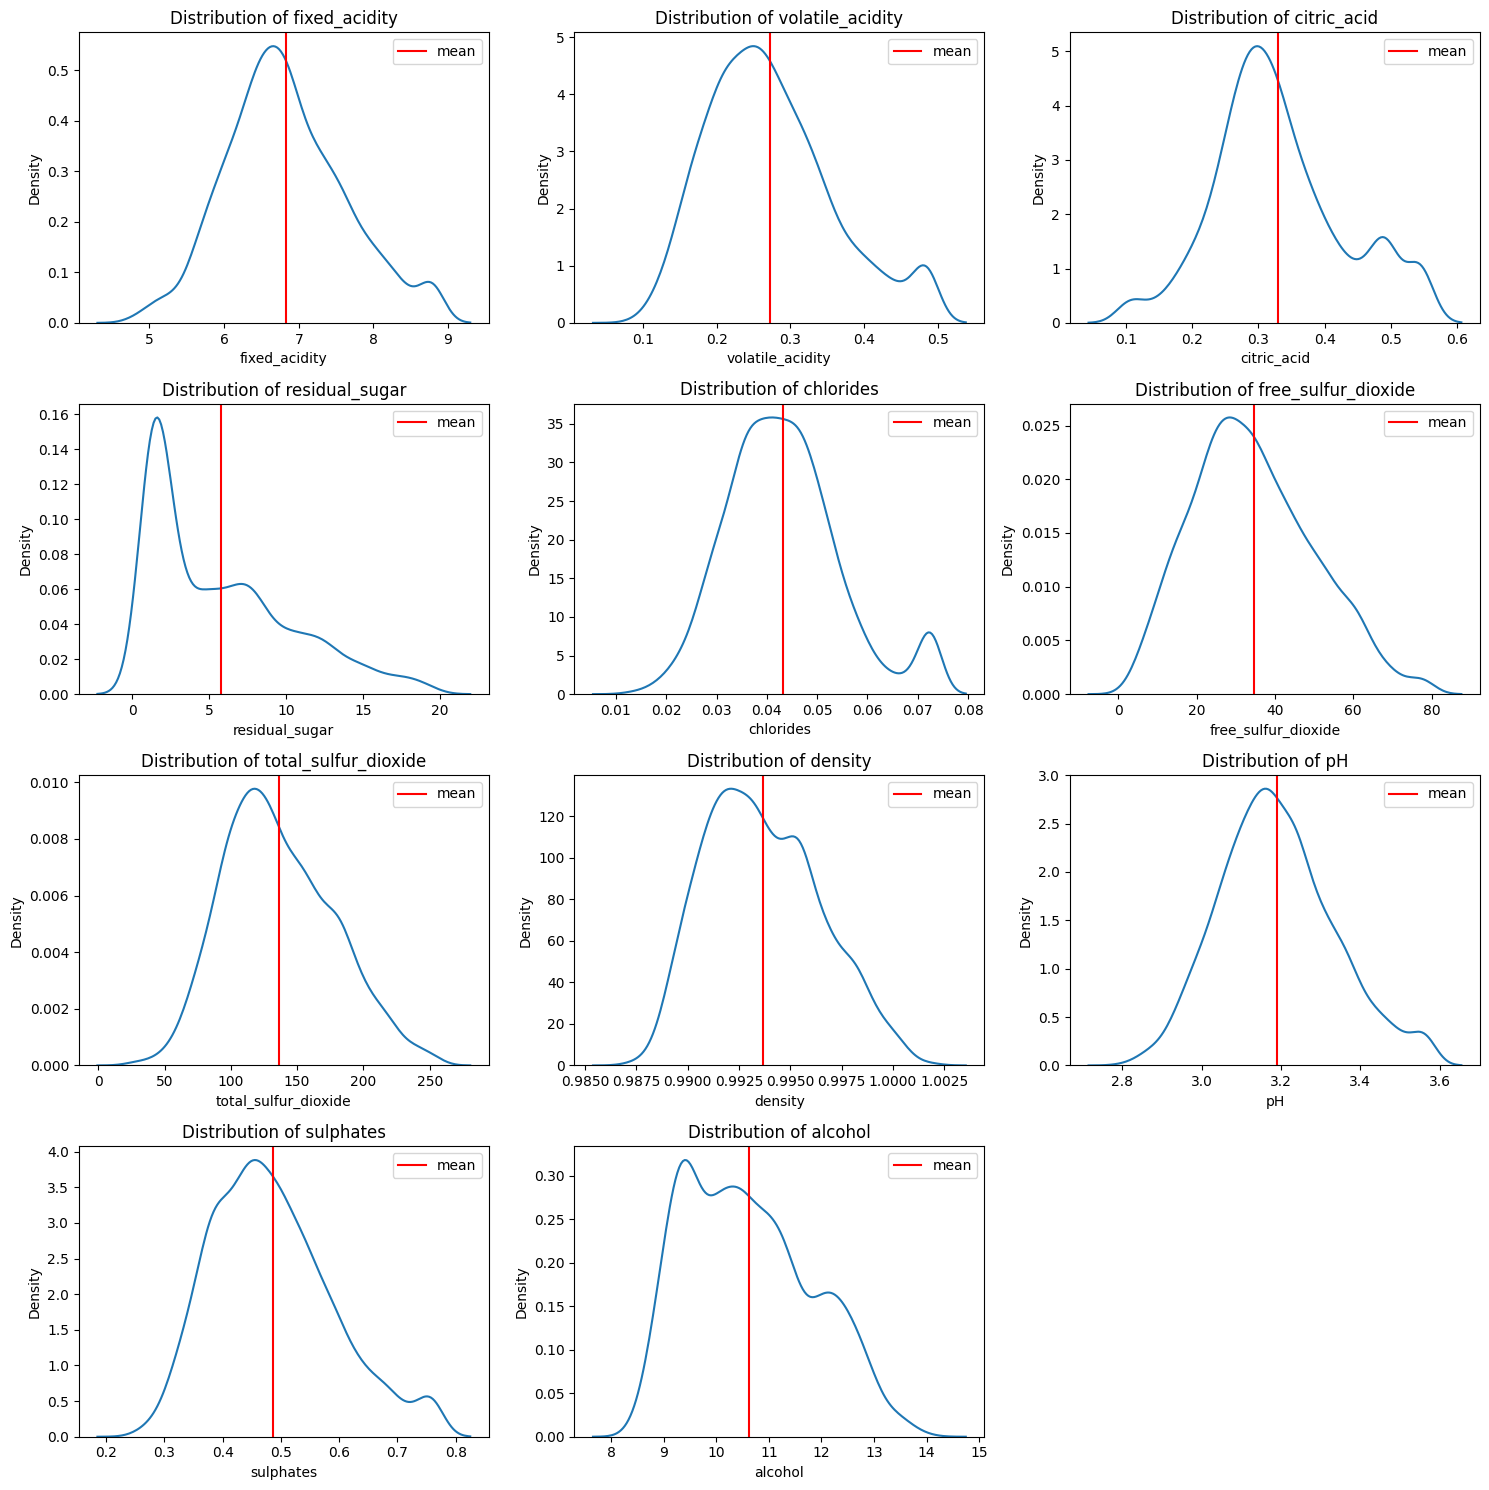

In [ ]:
fig = plt.figure(figsize = (15,15))

for feature_idx,feature in enumerate(features):
  plt.subplot(4,3,feature_idx + 1)
  sns.kdeplot(data = train_df,x = feature)
  plt.axvline(train_df[feature].mean(),color = 'red',label = 'mean')
  plt.title(f'Distribution of {feature}')
  plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures,PowerTransformer
numerical_transformer = Pipeline(steps = [
    ('normalize_distribution',PowerTransformer()),
    ('normalize_scale', StandardScaler()),
    #('impute_outliers',IterativeImputer())
])

numerical_transformer

Pipeline(steps=[('normalize_distribution', PowerTransformer()),
                ('normalize_scale', StandardScaler())])

In [ ]:
train_df[features] = numerical_transformer.fit_transform(train_df[features])
test_df[features] = numerical_transformer.transform(test_df[features])
submission_df[features] = numerical_transformer.transform(submission_df[features])

Feature Selection

<Axes: >

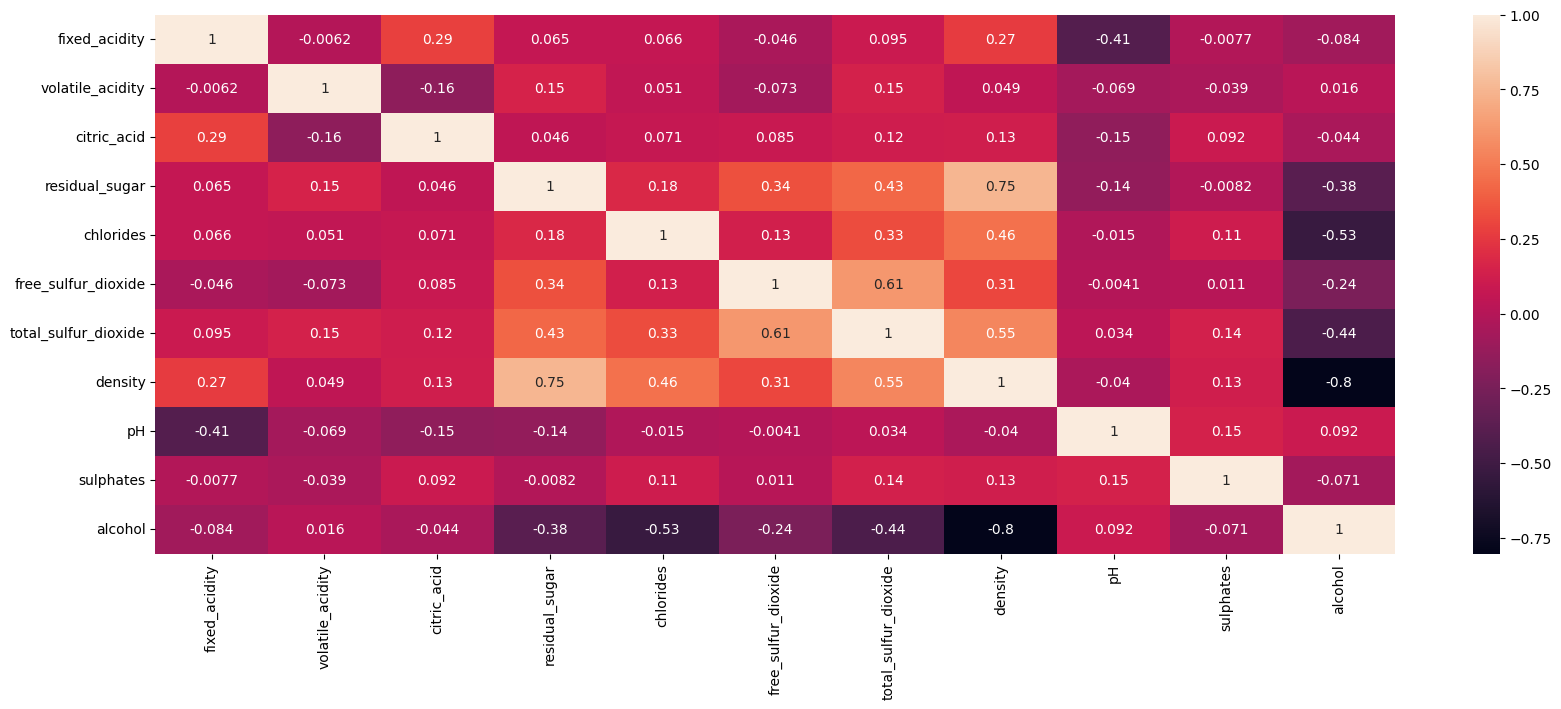

In [ ]:
fig = plt.figure(figsize = (20,7))
sns.heatmap(train_df.corr(numeric_only = True),annot = True)

In [ ]:
train_df.drop('density',axis = 1,inplace = True)
test_df.drop('density',axis = 1,inplace = True)
submission_df.drop('density',axis = 1,inplace = True)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

VarianceThreshold(threshold = 0).set_output(transform = 'pandas').fit_transform(train_df)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,quality
1042,-0.908399,0.859105,-0.144583,1.259340,0.904635,0.778599,2.194839,-0.153802,0.053644,-2.004551,2
2661,0.271178,0.759011,-0.467852,0.371587,-0.915161,0.370989,1.546015,-0.082667,1.397647,1.459066,3
2715,0.271178,-0.286043,-0.250833,1.288647,-0.704640,2.108071,0.886391,-1.463508,0.864290,-0.077216,3
1258,-0.496070,-0.029065,0.749357,-0.967344,2.185038,-2.395121,-2.102430,-0.669436,0.611131,-0.350169,2
756,0.745102,1.404272,-0.358578,0.307565,0.160133,-0.133372,-0.275126,0.788857,0.247558,0.501195,5
...,...,...,...,...,...,...,...,...,...,...,...
1130,2.211487,0.759011,0.165510,-1.151885,1.129191,-1.429494,0.864875,-0.370942,-0.046551,-0.740812,2
1294,0.629212,0.859105,-0.250833,-1.219217,1.201612,-0.547245,0.907847,0.530850,0.341398,-1.391991,3
860,1.512340,0.440922,1.544632,0.790493,-0.501068,-0.475699,0.929245,-0.593830,-2.155470,0.577789,4
3507,-0.768657,1.486724,-1.157558,-0.856657,-2.081137,-2.395121,-2.246229,-1.057637,2.157257,1.749654,4


Target categories imbalance treatment

<Axes: xlabel='quality', ylabel='count'>

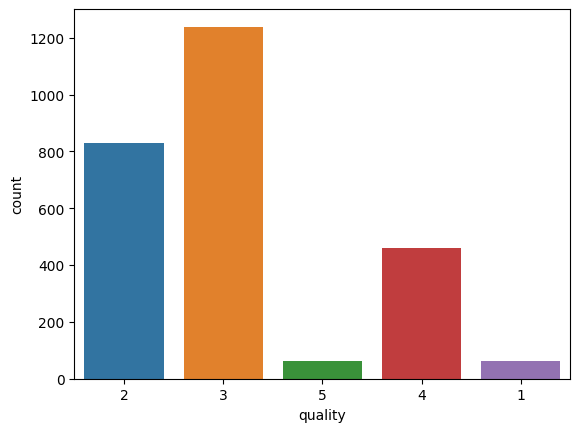

In [ ]:
sns.countplot(data = train_df,x = 'quality',hue = 'quality')

In [ ]:
features = [column for column in train_df.columns if column != 'quality']

In [ ]:
from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter

sm = SMOTE(random_state=42)
adasyn = ADASYN(random_state = 42)

X_train, y_train = adasyn.fit_resample(
    train_df[features], train_df
     ['quality'])
y_train = y_train.astype(int)
Counter(y_train)

Counter({2: 1232, 3: 1239, 5: 1224, 4: 1315, 1: 1229})

In [ ]:
#sulphates,citric_acidity
train_df.drop(['sulphates','citric_acid'],axis = 1,inplace = True)
test_df.drop(['sulphates','citric_acid'],axis = 1,inplace = True)
submission_df.drop(['sulphates','citric_acid'],axis = 1,inplace = True)

In [ ]:
features = [column for column in train_df.columns if column != 'quality']

In [ ]:
X_train = train_df[features]
y_train = train_df['quality']

X_test = test_df[features]
y_test = test_df['quality']

---
**5.Model Building**

---

In [ ]:
class Model(ABC):
  @abstractmethod
  def __init__(self):
    pass

  @abstractmethod
  def _objective(self):
    pass

  @abstractmethod
  def fit(self):
    pass

  @abstractmethod
  def predict(self):
    pass

  @abstractmethod
  def evaluation_accuracy(self):
    pass

In [ ]:
class Common:
  _strategy = None

  def __init__(self):
    self._study = None
    self.model = None
    self._best_score = None
    self._best_parameters = None


  def predict(self,X):
    return np.array(self.model.predict(X)).astype(int)

  def evaluation_accuracy(self,X_test,y_test):
    eval_prediction = self.model.predict(X_test)
    eval_accuracy = accuracy(y_test,eval_prediction)
    print(f'Accuracy on evaluation data: {eval_accuracy}')

  def _create_study(self):
    self._study = optuna.create_study(direction = 'maximize',sampler = optuna.samplers.TPESampler(seed=42))

  @property
  def best_score(self):
    print(f'Best Accuracy on Train Data: {self._best_score}')

  @property
  def best_parameters(self):
    print(f'Best Parameters for the model Based on Train Data')
    print('-' * 50)
    for key,value in self._best_parameters.items():
      print(f'{key}: {value}')
    print('-' * 50)

  @property
  def slice(self):
    return optuna.visualization.plot_slice(self._study)

  @property
  def optimization_history(self):
    return optuna.visualization.plot_optimization_history(self._study)

  @classmethod
  def strategy(cls):
    if cls._strategy != None:
      print(f'Current strategy: {cls._strategy}')

  @classmethod
  def change_strategy(cls,new_strategy):
    if cls._strategy != None:
      if new_strategy == 'ovo':
        cls._strategy = new_strategy
        print(f'Strategy switched to "{new_strategy}"')
      else:
        print(f'{new_strategy} is invalid stratedy')

In [ ]:
class Logistic_Regression(Model,Common):
  _strategy = 'ova'

  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    C = trial.suggest_float('C',0.001,10,step = 0.01)
    penalty = trial.suggest_categorical('penalty',['l1', 'l2'])
    solver = trial.suggest_categorical('solver',['liblinear'])
    if Logistic_Regression._strategy == 'ova':
      model = OneVsRestClassifier(LogisticRegression(C = C,penalty = penalty,solver = solver))
    else:
      model = OneVsOneClassifier(LogisticRegression(C = C,penalty = penalty,solver = solver))
    print(model)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    if Logistic_Regression._strategy == 'ova':
      self.model = OneVsRestClassifier(LogisticRegression(**self._best_parameters)).fit(self.X_train,self.y_train)
    else:
      self.model = OneVsOneClassifier(LogisticRegression(**self._best_parameters)).fit(self.X_train,self.y_train)

  def predict(self,X):
    return Common.predict(self,X)

  def evaluation_accuracy(self,X_test,y_test):
    return Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
lr = Logistic_Regression(X_train,y_train)
lr.fit(10)
lr.best_score
lr.evaluation_accuracy(X_test,y_test)

[I 2024-10-28 10:17:54,021] A new study created in memory with name: no-name-a1aca2a2-c33a-4d05-9014-5e21b889b3cf


OneVsRestClassifier(estimator=LogisticRegression(C=3.741, penalty='l1',
                                                 solver='liblinear'))


[I 2024-10-28 10:17:54,811] Trial 0 finished with value: 0.5736922147603312 and parameters: {'C': 3.741, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5736922147603312.


OneVsRestClassifier(estimator=LogisticRegression(C=5.981000000000001,
                                                 penalty='l1',
                                                 solver='liblinear'))


[I 2024-10-28 10:17:55,530] Trial 1 finished with value: 0.5740695732508971 and parameters: {'C': 5.981000000000001, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.5740695732508971.


OneVsRestClassifier(estimator=LogisticRegression(C=0.581, penalty='l1',
                                                 solver='liblinear'))


[I 2024-10-28 10:17:56,084] Trial 2 finished with value: 0.5729389190917813 and parameters: {'C': 0.581, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.5740695732508971.


OneVsRestClassifier(estimator=LogisticRegression(C=7.081, solver='liblinear'))


[I 2024-10-28 10:17:56,677] Trial 3 finished with value: 0.5748242902320293 and parameters: {'C': 7.081, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 3 with value: 0.5748242902320293.


OneVsRestClassifier(estimator=LogisticRegression(C=8.321, penalty='l1',
                                                 solver='liblinear'))


[I 2024-10-28 10:17:57,553] Trial 4 finished with value: 0.5748242902320293 and parameters: {'C': 8.321, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 3 with value: 0.5748242902320293.


OneVsRestClassifier(estimator=LogisticRegression(C=1.831, solver='liblinear'))


[I 2024-10-28 10:17:58,638] Trial 5 finished with value: 0.5740695732508971 and parameters: {'C': 1.831, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 3 with value: 0.5748242902320293.


OneVsRestClassifier(estimator=LogisticRegression(C=4.311000000000001,
                                                 solver='liblinear'))


[I 2024-10-28 10:18:00,138] Trial 6 finished with value: 0.5748242902320293 and parameters: {'C': 4.311000000000001, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 3 with value: 0.5748242902320293.


OneVsRestClassifier(estimator=LogisticRegression(C=1.391, solver='liblinear'))


[I 2024-10-28 10:18:01,376] Trial 7 finished with value: 0.5748235795757382 and parameters: {'C': 1.391, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 3 with value: 0.5748242902320293.


OneVsRestClassifier(estimator=LogisticRegression(C=4.561000000000001,
                                                 penalty='l1',
                                                 solver='liblinear'))


[I 2024-10-28 10:18:01,899] Trial 8 finished with value: 0.5736922147603312 and parameters: {'C': 4.561000000000001, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 3 with value: 0.5748242902320293.


OneVsRestClassifier(estimator=LogisticRegression(C=5.141, penalty='l1',
                                                 solver='liblinear'))


[I 2024-10-28 10:18:02,322] Trial 9 finished with value: 0.5740695732508971 and parameters: {'C': 5.141, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 3 with value: 0.5748242902320293.


Best Accuracy on Train Data: 0.5748242902320293
Accuracy on evaluation data: 0.5369318181818182


In [ ]:
lr.slice

In [ ]:
Logistic_Regression.change_strategy('ovo')
lr = Logistic_Regression(X_train,y_train)
lr.fit(20)
lr.best_score
lr.evaluation_accuracy(X_test,y_test)
lr.slice

[I 2024-10-28 10:18:02,766] A new study created in memory with name: no-name-47b1e55d-20c0-4696-b232-1c90ae7eb110


Strategy switched to "ovo"
OneVsOneClassifier(estimator=LogisticRegression(C=3.741, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:03,074] Trial 0 finished with value: 0.5755711899939594 and parameters: {'C': 3.741, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5755711899939594.


OneVsOneClassifier(estimator=LogisticRegression(C=5.981000000000001,
                                                penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:03,438] Trial 1 finished with value: 0.5751945421596845 and parameters: {'C': 5.981000000000001, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5755711899939594.


OneVsOneClassifier(estimator=LogisticRegression(C=0.581, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:03,733] Trial 2 finished with value: 0.5763244856625093 and parameters: {'C': 0.581, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=7.081, solver='liblinear'))


[I 2024-10-28 10:18:04,003] Trial 3 finished with value: 0.5751952528159755 and parameters: {'C': 7.081, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=8.321, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:04,328] Trial 4 finished with value: 0.5748178943254094 and parameters: {'C': 8.321, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=1.831, solver='liblinear'))


[I 2024-10-28 10:18:04,587] Trial 5 finished with value: 0.5755711899939594 and parameters: {'C': 1.831, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=4.311000000000001,
                                                solver='liblinear'))


[I 2024-10-28 10:18:04,850] Trial 6 finished with value: 0.5751952528159755 and parameters: {'C': 4.311000000000001, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=1.391, solver='liblinear'))


[I 2024-10-28 10:18:05,078] Trial 7 finished with value: 0.5755711899939594 and parameters: {'C': 1.391, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=4.561000000000001,
                                                penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:05,408] Trial 8 finished with value: 0.5755711899939594 and parameters: {'C': 4.561000000000001, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=5.141, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:05,751] Trial 9 finished with value: 0.5748171836691184 and parameters: {'C': 5.141, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value: 0.5763244856625093.


OneVsOneClassifier(estimator=LogisticRegression(C=0.201, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:06,022] Trial 10 finished with value: 0.5767018441530755 and parameters: {'C': 0.201, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 10 with value: 0.5767018441530755.


OneVsOneClassifier(estimator=LogisticRegression(C=0.07100000000000001,
                                                penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:06,321] Trial 11 finished with value: 0.5785893472621966 and parameters: {'C': 0.07100000000000001, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=0.14100000000000001,
                                                penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:06,561] Trial 12 finished with value: 0.5782098568027573 and parameters: {'C': 0.14100000000000001, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=2.601, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:06,847] Trial 13 finished with value: 0.5751938315033933 and parameters: {'C': 2.601, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=2.801, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:07,109] Trial 14 finished with value: 0.5751938315033933 and parameters: {'C': 2.801, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=9.671, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:07,396] Trial 15 finished with value: 0.5748178943254094 and parameters: {'C': 9.671, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=0.121, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:07,636] Trial 16 finished with value: 0.5774551398216252 and parameters: {'C': 0.121, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=1.4109999999999998,
                                                penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:07,887] Trial 17 finished with value: 0.5767018441530753 and parameters: {'C': 1.4109999999999998, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=3.211, solver='liblinear'))


[I 2024-10-28 10:18:08,123] Trial 18 finished with value: 0.5755719006502505 and parameters: {'C': 3.211, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


OneVsOneClassifier(estimator=LogisticRegression(C=2.061, penalty='l1',
                                                solver='liblinear'))


[I 2024-10-28 10:18:08,401] Trial 19 finished with value: 0.5759471271719433 and parameters: {'C': 2.061, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.5785893472621966.


Best Accuracy on Train Data: 0.5785893472621966
Accuracy on evaluation data: 0.5397727272727273


In [ ]:
class Support_Vector_Classifier(Model,Common):
  _strategy = 'ova'
  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    C = trial.suggest_float('C',0.1,10,step = 0.1)
    kernel = trial.suggest_categorical('kernel',['linear', 'rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma',['scale', 'auto'])
    if Support_Vector_Classifier._strategy == 'ova':
      model = OneVsRestClassifier(SVC(C = C,kernel = kernel,gamma = gamma))
    else:
      model = OneVsOneClassifier(SVC(C = C,kernel = kernel,gamma = gamma))
    print(model)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    if Support_Vector_Classifier._strategy == 'ova':
      self.model = OneVsRestClassifier(SVC(**self._best_parameters)).fit(X_train,y_train)
    else:
      self.model = OneVsOneClassifier(SVC(**self._best_parameters)).fit(X_train,y_train)

  def predict(self,X):
    return Common.predict(self,X)

  def evaluation_accuracy(self,X_test,y_test):
    return Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
svc = Support_Vector_Classifier(X_train,y_train)
svc.fit(20)
svc.best_score
svc.evaluation_accuracy(X_test,y_test)
svc.slice

[I 2024-10-28 10:18:08,538] A new study created in memory with name: no-name-efc027bf-529e-4d89-960a-d86593716ca4


OneVsRestClassifier(estimator=SVC(C=3.8000000000000003, kernel='linear'))


[I 2024-10-28 10:18:13,241] Trial 0 finished with value: 0.5571062075827026 and parameters: {'C': 3.8000000000000003, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.5571062075827026.


OneVsRestClassifier(estimator=SVC(C=0.6, gamma='auto', kernel='linear'))


[I 2024-10-28 10:18:16,548] Trial 1 finished with value: 0.5567309810610098 and parameters: {'C': 0.6, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.5571062075827026.


OneVsRestClassifier(estimator=SVC(C=8.4, gamma='auto', kernel='linear'))


[I 2024-10-28 10:18:22,636] Trial 2 finished with value: 0.5563529119141528 and parameters: {'C': 8.4, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.5571062075827026.


OneVsRestClassifier(estimator=SVC(C=4.3999999999999995, gamma='auto'))


[I 2024-10-28 10:18:26,237] Trial 3 finished with value: 0.5672756991081264 and parameters: {'C': 4.3999999999999995, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 3 with value: 0.5672756991081264.


OneVsRestClassifier(estimator=SVC(C=4.6, kernel='linear'))


[I 2024-10-28 10:18:31,998] Trial 4 finished with value: 0.5559755534235867 and parameters: {'C': 4.6, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.5672756991081264.


OneVsRestClassifier(estimator=SVC(C=6.1, kernel='poly'))


[I 2024-10-28 10:18:40,040] Trial 5 finished with value: 0.5555811391820347 and parameters: {'C': 6.1, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 3 with value: 0.5672756991081264.


OneVsRestClassifier(estimator=SVC(C=3.1, gamma='auto'))


[I 2024-10-28 10:18:44,814] Trial 6 finished with value: 0.570288881782326 and parameters: {'C': 3.1, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 6 with value: 0.570288881782326.


OneVsRestClassifier(estimator=SVC(C=0.4, gamma='auto', kernel='linear'))


[I 2024-10-28 10:18:46,899] Trial 7 finished with value: 0.5559762640798777 and parameters: {'C': 0.4, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 6 with value: 0.570288881782326.


OneVsRestClassifier(estimator=SVC(C=5.5))


[I 2024-10-28 10:18:50,504] Trial 8 finished with value: 0.5653931705930427 and parameters: {'C': 5.5, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 6 with value: 0.570288881782326.


OneVsRestClassifier(estimator=SVC(C=6.0, gamma='auto', kernel='linear'))


[I 2024-10-28 10:18:56,747] Trial 9 finished with value: 0.5571054969264116 and parameters: {'C': 6.0, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 6 with value: 0.570288881782326.


OneVsRestClassifier(estimator=SVC(C=2.5000000000000004, gamma='auto'))


[I 2024-10-28 10:19:00,219] Trial 10 finished with value: 0.5782034608961376 and parameters: {'C': 2.5000000000000004, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 10 with value: 0.5782034608961376.


OneVsRestClassifier(estimator=SVC(C=2.4000000000000004, gamma='auto'))


[I 2024-10-28 10:19:03,475] Trial 11 finished with value: 0.5774487439150054 and parameters: {'C': 2.4000000000000004, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 10 with value: 0.5782034608961376.


OneVsRestClassifier(estimator=SVC(C=2.2, gamma='auto'))


[I 2024-10-28 10:19:06,804] Trial 12 finished with value: 0.5770735173933128 and parameters: {'C': 2.2, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 10 with value: 0.5782034608961376.


OneVsRestClassifier(estimator=SVC(C=1.8000000000000003, gamma='auto'))


[I 2024-10-28 10:19:11,609] Trial 13 finished with value: 0.5819699392388872 and parameters: {'C': 1.8000000000000003, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 13 with value: 0.5819699392388872.


OneVsRestClassifier(estimator=SVC(C=1.5000000000000002, gamma='auto',
                                  kernel='poly'))


[I 2024-10-28 10:19:16,456] Trial 14 finished with value: 0.5570877305191344 and parameters: {'C': 1.5000000000000002, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 13 with value: 0.5819699392388872.


OneVsRestClassifier(estimator=SVC(C=7.6, gamma='auto'))


[I 2024-10-28 10:19:20,308] Trial 15 finished with value: 0.5601165476317379 and parameters: {'C': 7.6, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 13 with value: 0.5819699392388872.


OneVsRestClassifier(estimator=SVC(C=1.4000000000000001, gamma='auto'))


[I 2024-10-28 10:19:25,018] Trial 16 finished with value: 0.583100593398003 and parameters: {'C': 1.4000000000000001, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 16 with value: 0.583100593398003.


OneVsRestClassifier(estimator=SVC(C=9.8, gamma='auto', kernel='poly'))


[I 2024-10-28 10:19:36,014] Trial 17 finished with value: 0.5521856234232313 and parameters: {'C': 9.8, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 16 with value: 0.583100593398003.


OneVsRestClassifier(estimator=SVC(C=1.2000000000000002))


[I 2024-10-28 10:19:40,305] Trial 18 finished with value: 0.5834800838574423 and parameters: {'C': 1.2000000000000002, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 18 with value: 0.5834800838574423.


OneVsRestClassifier(estimator=SVC(C=0.2))


[I 2024-10-28 10:19:43,204] Trial 19 finished with value: 0.5827360267206765 and parameters: {'C': 0.2, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 18 with value: 0.5834800838574423.


Best Accuracy on Train Data: 0.5834800838574423
Accuracy on evaluation data: 0.5397727272727273


In [ ]:
Support_Vector_Classifier.change_strategy('ovo')
svc = Support_Vector_Classifier(X_train,y_train)
svc.fit(20)
svc.best_score
svc.evaluation_accuracy(X_test,y_test)
svc.slice

[I 2024-10-28 10:19:44,319] A new study created in memory with name: no-name-fa2cb413-ed8e-4055-b529-132ed823b8f1


Strategy switched to "ovo"
OneVsOneClassifier(estimator=SVC(C=3.8000000000000003, kernel='linear'))


[I 2024-10-28 10:19:46,589] Trial 0 finished with value: 0.5631375475251394 and parameters: {'C': 3.8000000000000003, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.5631375475251394.


OneVsOneClassifier(estimator=SVC(C=0.6, gamma='auto', kernel='linear'))


[I 2024-10-28 10:19:47,963] Trial 1 finished with value: 0.5627608996908645 and parameters: {'C': 0.6, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.5631375475251394.


OneVsOneClassifier(estimator=SVC(C=8.4, gamma='auto', kernel='linear'))


[I 2024-10-28 10:19:52,545] Trial 2 finished with value: 0.5631375475251394 and parameters: {'C': 8.4, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.5631375475251394.


OneVsOneClassifier(estimator=SVC(C=4.3999999999999995, gamma='auto'))


[I 2024-10-28 10:19:54,940] Trial 3 finished with value: 0.575568347368795 and parameters: {'C': 4.3999999999999995, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 3 with value: 0.575568347368795.


OneVsOneClassifier(estimator=SVC(C=4.6, kernel='linear'))


[I 2024-10-28 10:19:57,320] Trial 4 finished with value: 0.5631375475251394 and parameters: {'C': 4.6, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 3 with value: 0.575568347368795.


OneVsOneClassifier(estimator=SVC(C=6.1, kernel='poly'))


[I 2024-10-28 10:20:00,567] Trial 5 finished with value: 0.5533248054578404 and parameters: {'C': 6.1, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 3 with value: 0.575568347368795.


OneVsOneClassifier(estimator=SVC(C=3.1, gamma='auto'))


[I 2024-10-28 10:20:02,907] Trial 6 finished with value: 0.5770749387058949 and parameters: {'C': 3.1, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 6 with value: 0.5770749387058949.


OneVsOneClassifier(estimator=SVC(C=0.4, gamma='auto', kernel='linear'))


[I 2024-10-28 10:20:05,107] Trial 7 finished with value: 0.5631375475251394 and parameters: {'C': 0.4, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 6 with value: 0.5770749387058949.


OneVsOneClassifier(estimator=SVC(C=5.5))


[I 2024-10-28 10:20:08,164] Trial 8 finished with value: 0.5669033152115979 and parameters: {'C': 5.5, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 6 with value: 0.5770749387058949.


OneVsOneClassifier(estimator=SVC(C=6.0, gamma='auto', kernel='linear'))


[I 2024-10-28 10:20:10,915] Trial 9 finished with value: 0.5631375475251394 and parameters: {'C': 6.0, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 6 with value: 0.5770749387058949.


OneVsOneClassifier(estimator=SVC(C=2.5000000000000004, gamma='auto'))


[I 2024-10-28 10:20:13,268] Trial 10 finished with value: 0.5849923604448708 and parameters: {'C': 2.5000000000000004, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 10 with value: 0.5849923604448708.


OneVsOneClassifier(estimator=SVC(C=2.4000000000000004, gamma='auto'))


[I 2024-10-28 10:20:15,893] Trial 11 finished with value: 0.5842383541200299 and parameters: {'C': 2.4000000000000004, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 10 with value: 0.5849923604448708.


OneVsOneClassifier(estimator=SVC(C=2.2, gamma='auto'))


[I 2024-10-28 10:20:19,436] Trial 12 finished with value: 0.5861215932914046 and parameters: {'C': 2.2, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 12 with value: 0.5861215932914046.


OneVsOneClassifier(estimator=SVC(C=1.7000000000000002, gamma='auto'))


[I 2024-10-28 10:20:22,146] Trial 13 finished with value: 0.5876288952847956 and parameters: {'C': 1.7000000000000002, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 13 with value: 0.5876288952847956.


OneVsOneClassifier(estimator=SVC(C=1.5000000000000002, gamma='auto',
                                 kernel='poly'))


[I 2024-10-28 10:20:24,167] Trial 14 finished with value: 0.5570863092065523 and parameters: {'C': 1.5000000000000002, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 13 with value: 0.5876288952847956.


OneVsOneClassifier(estimator=SVC(C=7.6, gamma='auto'))


[I 2024-10-28 10:20:26,661] Trial 15 finished with value: 0.5616281135628753 and parameters: {'C': 7.6, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 13 with value: 0.5876288952847956.


OneVsOneClassifier(estimator=SVC(C=1.5000000000000002, gamma='auto'))


[I 2024-10-28 10:20:28,829] Trial 16 finished with value: 0.5876296059410866 and parameters: {'C': 1.5000000000000002, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 16 with value: 0.5876296059410866.


OneVsOneClassifier(estimator=SVC(C=9.8, gamma='auto', kernel='poly'))


[I 2024-10-28 10:20:34,410] Trial 17 finished with value: 0.5480446292150802 and parameters: {'C': 9.8, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 16 with value: 0.5876296059410866.


OneVsOneClassifier(estimator=SVC(C=1.2000000000000002))


[I 2024-10-28 10:20:36,581] Trial 18 finished with value: 0.5891404612159329 and parameters: {'C': 1.2000000000000002, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 18 with value: 0.5891404612159329.


OneVsOneClassifier(estimator=SVC(C=0.2))


[I 2024-10-28 10:20:40,086] Trial 19 finished with value: 0.5744426678037167 and parameters: {'C': 0.2, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 18 with value: 0.5891404612159329.


Best Accuracy on Train Data: 0.5891404612159329
Accuracy on evaluation data: 0.5440340909090909


In [ ]:
class KNeighbors_Classifier(Model,Common):
  _strategy = 'ova'

  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    n_neighbors = trial.suggest_int('n_neighbors',1,15)
    weights = trial.suggest_categorical('weights',['uniform', 'distance'])
    metric = trial.suggest_categorical('metric',['euclidean', 'manhattan'])
    if KNeighbors_Classifier._strategy == 'ova':
      model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = n_neighbors,weights = weights,metric = metric))
    else:
      model = OneVsOneClassifier(KNeighborsClassifier(n_neighbors = n_neighbors,weights = weights,metric = metric))
    print(model)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    if KNeighbors_Classifier._strategy == 'ova':
      self.model = OneVsRestClassifier(KNeighborsClassifier(**self._best_parameters)).fit(X_train,y_train)
    else:
      self.model = OneVsOneClassifier(KNeighborsClassifier(**self._best_parameters)).fit(X_train,y_train)

  def predict(self,X):
    return Common.predict(self,X)

  def evaluation_accuracy(self,X_test,y_test):
    return Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
knc = KNeighbors_Classifier(X_train,y_train)
knc.fit(20)
knc.best_score
knc.evaluation_accuracy(X_test,y_test)
knc.slice

[I 2024-10-28 10:20:40,861] A new study created in memory with name: no-name-d40240ec-c4fd-43c3-9803-6842452ecb47


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=6))


[I 2024-10-28 10:20:41,506] Trial 0 finished with value: 0.5126283622925772 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.5126283622925772.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=3,
                                                   weights='distance'))


[I 2024-10-28 10:20:42,335] Trial 1 finished with value: 0.5280673702163948 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.5280673702163948.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=1))


[I 2024-10-28 10:20:42,828] Trial 2 finished with value: 0.5028255694133532 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.5280673702163948.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=3,
                                                   weights='distance'))


[I 2024-10-28 10:20:43,397] Trial 3 finished with value: 0.5318437977472195 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 3 with value: 0.5318437977472195.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=10,
                                                   weights='distance'))


[I 2024-10-28 10:20:44,436] Trial 4 finished with value: 0.5540944462210853 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.5540944462210853.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=12,
                                                   weights='distance'))


[I 2024-10-28 10:20:45,537] Trial 5 finished with value: 0.5642532779021426 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5642532779021426.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=10))


[I 2024-10-28 10:20:47,040] Trial 6 finished with value: 0.534495967025548 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 5 with value: 0.5642532779021426.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=13))


[I 2024-10-28 10:20:48,081] Trial 7 finished with value: 0.5548278435134847 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5642532779021426.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=2))


[I 2024-10-28 10:20:48,597] Trial 8 finished with value: 0.47983015314643074 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5642532779021426.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=10,
                                                   weights='distance'))


[I 2024-10-28 10:20:49,286] Trial 9 finished with value: 0.5559677362043847 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5642532779021426.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=15,
                                                   weights='distance'))


[I 2024-10-28 10:20:50,294] Trial 10 finished with value: 0.5650143907898945 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=15,
                                                   weights='distance'))


[I 2024-10-28 10:20:51,296] Trial 11 finished with value: 0.5650143907898945 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=15,
                                                   weights='distance'))


[I 2024-10-28 10:20:52,289] Trial 12 finished with value: 0.5650143907898945 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=15,
                                                   weights='distance'))


[I 2024-10-28 10:20:53,284] Trial 13 finished with value: 0.5650143907898945 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=13,
                                                   weights='distance'))


[I 2024-10-28 10:20:54,268] Trial 14 finished with value: 0.556723874498099 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=7,
                                                   weights='distance'))


[I 2024-10-28 10:20:55,190] Trial 15 finished with value: 0.5435312511104005 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=15,
                                                   weights='distance'))


[I 2024-10-28 10:20:56,219] Trial 16 finished with value: 0.5650143907898945 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=12,
                                                   weights='distance'))


[I 2024-10-28 10:20:57,191] Trial 17 finished with value: 0.557854528657215 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=13,
                                                   weights='distance'))


[I 2024-10-28 10:20:58,321] Trial 18 finished with value: 0.556723874498099 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


OneVsRestClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=8,
                                                   weights='distance'))


[I 2024-10-28 10:20:59,779] Trial 19 finished with value: 0.5412813132928259 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.5650143907898945.


Best Accuracy on Train Data: 0.5650143907898945
Accuracy on evaluation data: 0.5525568181818182


In [ ]:
KNeighbors_Classifier.change_strategy('ovo')
knc = KNeighbors_Classifier(X_train,y_train)
knc.fit(20)
knc.best_score
knc.evaluation_accuracy(X_test,y_test)
knc.slice

[I 2024-10-28 10:21:00,336] A new study created in memory with name: no-name-971e619f-b622-4d78-a96e-9590eedf099e


Strategy switched to "ovo"
OneVsOneClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                  n_neighbors=6))


[I 2024-10-28 10:21:03,198] Trial 0 finished with value: 0.537880822939985 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.537880822939985.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=3,
                                                  weights='distance'))


[I 2024-10-28 10:21:04,533] Trial 1 finished with value: 0.5389965533169883 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 1 with value: 0.5389965533169883.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                  n_neighbors=1))


[I 2024-10-28 10:21:06,612] Trial 2 finished with value: 0.5028255694133532 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 1 with value: 0.5389965533169883.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                  n_neighbors=3,
                                                  weights='distance'))


[I 2024-10-28 10:21:07,488] Trial 3 finished with value: 0.546921081618875 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 3 with value: 0.546921081618875.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=10,
                                                  weights='distance'))


[I 2024-10-28 10:21:08,987] Trial 4 finished with value: 0.561248623103436 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 4 with value: 0.561248623103436.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                  n_neighbors=12,
                                                  weights='distance'))


[I 2024-10-28 10:21:10,170] Trial 5 finished with value: 0.5650094161958569 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5650094161958569.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=10))


[I 2024-10-28 10:21:13,937] Trial 6 finished with value: 0.5480595529971929 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 5 with value: 0.5650094161958569.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                  n_neighbors=13))


[I 2024-10-28 10:21:19,091] Trial 7 finished with value: 0.563502824858757 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5650094161958569.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                  n_neighbors=2))


[I 2024-10-28 10:21:21,335] Trial 8 finished with value: 0.4967920975020432 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5650094161958569.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='euclidean',
                                                  n_neighbors=10,
                                                  weights='distance'))


[I 2024-10-28 10:21:22,434] Trial 9 finished with value: 0.5623771452936788 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 5 with value: 0.5650094161958569.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=15,
                                                  weights='distance'))


[I 2024-10-28 10:21:24,054] Trial 10 finished with value: 0.569157516966919 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=15,
                                                  weights='distance'))


[I 2024-10-28 10:21:25,713] Trial 11 finished with value: 0.569157516966919 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=15,
                                                  weights='distance'))


[I 2024-10-28 10:21:27,487] Trial 12 finished with value: 0.569157516966919 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=15,
                                                  weights='distance'))


[I 2024-10-28 10:21:29,992] Trial 13 finished with value: 0.569157516966919 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=13,
                                                  weights='distance'))


[I 2024-10-28 10:21:31,833] Trial 14 finished with value: 0.5653903279678782 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=7,
                                                  weights='distance'))


[I 2024-10-28 10:21:33,270] Trial 15 finished with value: 0.5503258359094624 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=15,
                                                  weights='distance'))


[I 2024-10-28 10:21:34,884] Trial 16 finished with value: 0.569157516966919 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=12,
                                                  weights='distance'))


[I 2024-10-28 10:21:36,483] Trial 17 finished with value: 0.559362541306897 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=13,
                                                  weights='distance'))


[I 2024-10-28 10:21:38,042] Trial 18 finished with value: 0.5653903279678782 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


OneVsOneClassifier(estimator=KNeighborsClassifier(metric='manhattan',
                                                  n_neighbors=8,
                                                  weights='distance'))


[I 2024-10-28 10:21:39,502] Trial 19 finished with value: 0.5473055466723519 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 10 with value: 0.569157516966919.


Best Accuracy on Train Data: 0.569157516966919
Accuracy on evaluation data: 0.5582386363636364


In [ ]:
class Decision_Tree_Classifier(Model,Common):
  _strategy = 'ova'

  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    max_depth = trial.suggest_int('max_depth',1,20)
    min_samples_split = trial.suggest_int('min_samples_split',2,20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2,20)
    max_features = trial.suggest_categorical('max_features',['sqrt', 'log2'])
    if Decision_Tree_Classifier._strategy == 'ova':
      model = OneVsRestClassifier(DecisionTreeClassifier(max_depth = max_depth,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_features = max_features))
    else:
      model = OneVsOneClassifier(DecisionTreeClassifier(max_depth = max_depth,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     max_features = max_features))
    print(model)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    if Decision_Tree_Classifier._strategy == 'ova':
      self.model = OneVsRestClassifier(DecisionTreeClassifier(**self._best_parameters)).fit(X_train,y_train)
    else:
      self.model = OneVsOneClassifier(DecisionTreeClassifier(**self._best_parameters)).fit(X_train,y_train)

  def predict(self,X):
    return Common.predict(self,X)

  def evaluation_accuracy(self,X_test,y_test):
    return Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
dtc = Decision_Tree_Classifier(X_train,y_train)
dtc.fit(20)
dtc.best_score
dtc.evaluation_accuracy(X_test,y_test)
dtc.slice

[I 2024-10-28 10:21:40,086] A new study created in memory with name: no-name-658eb410-d1e3-49c8-9ead-52c9b4365d25


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                     max_features='sqrt',
                                                     min_samples_leaf=15,
                                                     min_samples_split=20))


[I 2024-10-28 10:21:40,341] Trial 0 finished with value: 0.5235667839249547 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5235667839249547.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                     max_features='log2',
                                                     min_samples_leaf=18,
                                                     min_samples_split=3))


[I 2024-10-28 10:21:40,571] Trial 1 finished with value: 0.5367508794371603 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                     max_features='sqrt',
                                                     min_samples_leaf=17,
                                                     min_samples_split=20))


[I 2024-10-28 10:21:40,817] Trial 2 finished with value: 0.487758234729773 and parameters: {'max_depth': 1, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                     max_features='sqrt',
                                                     min_samples_leaf=11,
                                                     min_samples_split=7))


[I 2024-10-28 10:21:41,139] Trial 3 finished with value: 0.5352357602245674 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=13,
                                                     max_features='log2',
                                                     min_samples_leaf=7,
                                                     min_samples_split=4))


[I 2024-10-28 10:21:41,569] Trial 4 finished with value: 0.5137604377642753 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=16,
                                                     max_features='sqrt',
                                                     min_samples_leaf=11,
                                                     min_samples_split=5))


[I 2024-10-28 10:21:41,922] Trial 5 finished with value: 0.5096123369932133 and parameters: {'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=13,
                                                     max_features='log2',
                                                     min_samples_leaf=3,
                                                     min_samples_split=5))


[I 2024-10-28 10:21:42,360] Trial 6 finished with value: 0.4609785737128238 and parameters: {'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=17,
                                                     max_features='sqrt',
                                                     min_samples_leaf=3,
                                                     min_samples_split=7))


[I 2024-10-28 10:21:42,749] Trial 7 finished with value: 0.4670177308744625 and parameters: {'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     min_samples_split=11))


[I 2024-10-28 10:21:43,067] Trial 8 finished with value: 0.5212756280424972 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                     max_features='sqrt',
                                                     min_samples_leaf=11,
                                                     min_samples_split=7))


[I 2024-10-28 10:21:43,463] Trial 9 finished with value: 0.5209032441459689 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5367508794371603.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                     max_features='log2',
                                                     min_samples_leaf=20,
                                                     min_samples_split=14))


[I 2024-10-28 10:21:43,880] Trial 10 finished with value: 0.5427765341292684 and parameters: {'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 10 with value: 0.5427765341292684.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                     max_features='log2',
                                                     min_samples_leaf=20,
                                                     min_samples_split=15))


[I 2024-10-28 10:21:44,305] Trial 11 finished with value: 0.5522048111430907 and parameters: {'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                     max_features='log2',
                                                     min_samples_leaf=20,
                                                     min_samples_split=15))


[I 2024-10-28 10:21:44,664] Trial 12 finished with value: 0.5416515652204812 and parameters: {'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                     max_features='log2',
                                                     min_samples_leaf=15,
                                                     min_samples_split=15))


[I 2024-10-28 10:21:44,932] Trial 13 finished with value: 0.5378794016274029 and parameters: {'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                     max_features='log2',
                                                     min_samples_leaf=20,
                                                     min_samples_split=15))


[I 2024-10-28 10:21:45,213] Trial 14 finished with value: 0.5390043705361902 and parameters: {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                     max_features='log2',
                                                     min_samples_leaf=14,
                                                     min_samples_split=12))


[I 2024-10-28 10:21:45,491] Trial 15 finished with value: 0.5461784457946914 and parameters: {'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                     max_features='log2',
                                                     min_samples_leaf=14,
                                                     min_samples_split=11))


[I 2024-10-28 10:21:45,756] Trial 16 finished with value: 0.551068471733646 and parameters: {'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=20,
                                                     max_features='log2',
                                                     min_samples_leaf=8,
                                                     min_samples_split=10))


[I 2024-10-28 10:21:46,069] Trial 17 finished with value: 0.5118629854670789 and parameters: {'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=11,
                                                     max_features='log2',
                                                     min_samples_leaf=17,
                                                     min_samples_split=18))


[I 2024-10-28 10:21:46,358] Trial 18 finished with value: 0.5393945208399957 and parameters: {'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


OneVsRestClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                     max_features='log2',
                                                     min_samples_leaf=13,
                                                     min_samples_split=17))


[I 2024-10-28 10:21:46,613] Trial 19 finished with value: 0.5480659489038127 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 11 with value: 0.5522048111430907.


Best Accuracy on Train Data: 0.5522048111430907
Accuracy on evaluation data: 0.53125


In [ ]:
Decision_Tree_Classifier.change_strategy('ovo')
dtc = Decision_Tree_Classifier(X_train,y_train)
dtc.fit(20)
dtc.best_score
dtc.evaluation_accuracy(X_test,y_test)
dtc.slice

[I 2024-10-28 10:21:46,759] A new study created in memory with name: no-name-161e0e60-93b1-457a-a4bc-04ae494ba3d5


Strategy switched to "ovo"
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                    max_features='sqrt',
                                                    min_samples_leaf=15,
                                                    min_samples_split=20))


[I 2024-10-28 10:21:46,980] Trial 0 finished with value: 0.5374970685427993 and parameters: {'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5374970685427993.
[I 2024-10-28 10:21:47,176] Trial 1 finished with value: 0.5476942756635752 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    max_features='log2',
                                                    min_samples_leaf=18,
                                                    min_samples_split=3))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    max_features='sqrt',
                                                    min_samples_leaf=17,
                                                    min_samples_split=20))


[I 2024-10-28 10:21:47,377] Trial 2 finished with value: 0.48135522154709875 and parameters: {'max_depth': 1, 'min_samples_split': 20, 'min_samples_leaf': 17, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5476942756635752.
[I 2024-10-28 10:21:47,579] Trial 3 finished with value: 0.5209082187400064 and parameters: {'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    max_features='sqrt',
                                                    min_samples_leaf=11,
                                                    min_samples_split=7))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=13,
                                                    max_features='log2',
                                                    min_samples_leaf=7,
                                                    min_samples_split=4))


[I 2024-10-28 10:21:47,817] Trial 4 finished with value: 0.48738300820808006 and parameters: {'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.
[I 2024-10-28 10:21:48,010] Trial 5 finished with value: 0.5130057207831433 and parameters: {'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=16,
                                                    max_features='sqrt',
                                                    min_samples_leaf=11,
                                                    min_samples_split=5))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=13,
                                                    max_features='log2',
                                                    min_samples_leaf=3,
                                                    min_samples_split=5))


[I 2024-10-28 10:21:48,253] Trial 6 finished with value: 0.49565149415485205 and parameters: {'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=17,
                                                    max_features='sqrt',
                                                    min_samples_leaf=3,
                                                    min_samples_split=7))


[I 2024-10-28 10:21:48,480] Trial 7 finished with value: 0.4802146181999076 and parameters: {'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5476942756635752.
[I 2024-10-28 10:21:48,653] Trial 8 finished with value: 0.5084802615215152 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=3,
                                                    max_features='sqrt',
                                                    min_samples_leaf=2,
                                                    min_samples_split=11))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=14,
                                                    max_features='sqrt',
                                                    min_samples_leaf=11,
                                                    min_samples_split=7))


[I 2024-10-28 10:21:48,855] Trial 9 finished with value: 0.49943787087375185 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5476942756635752.
[I 2024-10-28 10:21:49,076] Trial 10 finished with value: 0.5273218917670468 and parameters: {'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                    max_features='log2',
                                                    min_samples_leaf=20,
                                                    min_samples_split=14))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=8,
                                                    max_features='log2',
                                                    min_samples_leaf=16,
                                                    min_samples_split=19))


[I 2024-10-28 10:21:49,325] Trial 11 finished with value: 0.5212926837934833 and parameters: {'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=7,
                                                    max_features='log2',
                                                    min_samples_leaf=15,
                                                    min_samples_split=16))


[I 2024-10-28 10:21:49,572] Trial 12 finished with value: 0.5284603631453646 and parameters: {'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.
[I 2024-10-28 10:21:49,799] Trial 13 finished with value: 0.5356138293714244 and parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    max_features='log2',
                                                    min_samples_leaf=20))


[I 2024-10-28 10:21:50,021] Trial 14 finished with value: 0.5043435312511104 and parameters: {'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    max_features='sqrt',
                                                    min_samples_leaf=14,
                                                    min_samples_split=11))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                    max_features='log2',
                                                    min_samples_leaf=17,
                                                    min_samples_split=15))


[I 2024-10-28 10:21:50,269] Trial 15 finished with value: 0.5416572504708098 and parameters: {'max_depth': 6, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.
[I 2024-10-28 10:21:50,471] Trial 16 finished with value: 0.5130057207831433 and parameters: {'max_depth': 1, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    max_features='log2',
                                                    min_samples_leaf=18,
                                                    min_samples_split=14))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=20,
                                                    max_features='log2',
                                                    min_samples_leaf=13,
                                                    min_samples_split=16))


[I 2024-10-28 10:21:50,708] Trial 17 finished with value: 0.5164140283551861 and parameters: {'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.
[I 2024-10-28 10:21:50,926] Trial 18 finished with value: 0.531093344703834 and parameters: {'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 18, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=6,
                                                    max_features='log2',
                                                    min_samples_leaf=18,
                                                    min_samples_split=10))
OneVsOneClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    max_features='log2',
                                                    min_samples_leaf=6,
                                                    min_samples_split=9))


[I 2024-10-28 10:21:51,180] Trial 19 finished with value: 0.5073474753935259 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 1 with value: 0.5476942756635752.


Best Accuracy on Train Data: 0.5476942756635752
Accuracy on evaluation data: 0.47301136363636365


In [ ]:
class AdaBoost_Classifier(Model,Common):
  _strategy = 'ova'

  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    n_estimators = trial.suggest_int('n_estimators',100,1000)
    learning_rate = trial.suggest_float('learning_rate',0.001,1,step = 0.01)
    estimator = DecisionTreeClassifier()
    if AdaBoost_Classifier._strategy == 'ova':
      model = OneVsRestClassifier(AdaBoostClassifier(n_estimators = n_estimators,
                               learning_rate = learning_rate,
                               estimator = estimator))
    else:
      model = OneVsRestClassifier(AdaBoostClassifier(n_estimators = n_estimators,
                               learning_rate = learning_rate,
                               estimator = estimator))
    print(model)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    if AdaBoost_Classifier._strategy == 'ova':
      self.model = OneVsRestClassifier(AdaBoostClassifier(**self._best_parameters)).fit(X_train,y_train)
    else:
      self.model = OneVsOneClassifier(AdaBoostClassifier(**self._best_parameters)).fit(X_train,y_train)

  def predict(self,X):
    return Common.predict(self,X)

  def evaluation_accuracy(self,X_test,y_test):
    return Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
ada = AdaBoost_Classifier(X_train,y_train)
ada.fit(20)
ada.best_score
ada.evaluation_accuracy(X_test,y_test)
ada.slice

[I 2024-10-28 10:21:51,321] A new study created in memory with name: no-name-54f373be-2317-451c-8890-f88d91191c3b


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.9510000000000001,
                                                 n_estimators=437))


[I 2024-10-28 10:21:51,858] Trial 0 finished with value: 0.36298688839142945 and parameters: {'n_estimators': 437, 'learning_rate': 0.9510000000000001}. Best is trial 0 with value: 0.36298688839142945.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.591,
                                                 n_estimators=759))


[I 2024-10-28 10:21:52,377] Trial 1 finished with value: 0.3667512347653058 and parameters: {'n_estimators': 759, 'learning_rate': 0.591}. Best is trial 1 with value: 0.3667512347653058.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.151,
                                                 n_estimators=240))


[I 2024-10-28 10:21:52,898] Trial 2 finished with value: 0.3686422911558825 and parameters: {'n_estimators': 240, 'learning_rate': 0.151}. Best is trial 2 with value: 0.3686422911558825.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.861,
                                                 n_estimators=152))


[I 2024-10-28 10:21:53,414] Trial 3 finished with value: 0.36524677539707917 and parameters: {'n_estimators': 152, 'learning_rate': 0.861}. Best is trial 2 with value: 0.3686422911558825.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.7010000000000001,
                                                 n_estimators=641))


[I 2024-10-28 10:21:53,941] Trial 4 finished with value: 0.35921472479835126 and parameters: {'n_estimators': 641, 'learning_rate': 0.7010000000000001}. Best is trial 2 with value: 0.3686422911558825.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.961,
                                                 n_estimators=118))


[I 2024-10-28 10:21:54,456] Trial 5 finished with value: 0.36487225953167746 and parameters: {'n_estimators': 118, 'learning_rate': 0.961}. Best is trial 2 with value: 0.3686422911558825.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.211,
                                                 n_estimators=850))


[I 2024-10-28 10:21:55,165] Trial 6 finished with value: 0.36940056141846994 and parameters: {'n_estimators': 850, 'learning_rate': 0.211}. Best is trial 6 with value: 0.36940056141846994.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.181,
                                                 n_estimators=263))


[I 2024-10-28 10:21:55,905] Trial 7 finished with value: 0.3603453789574672 and parameters: {'n_estimators': 263, 'learning_rate': 0.181}. Best is trial 6 with value: 0.36940056141846994.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.521,
                                                 n_estimators=374))


[I 2024-10-28 10:21:56,655] Trial 8 finished with value: 0.36298404576626514 and parameters: {'n_estimators': 374, 'learning_rate': 0.521}. Best is trial 6 with value: 0.36940056141846994.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.291,
                                                 n_estimators=489))


[I 2024-10-28 10:21:57,443] Trial 9 finished with value: 0.36298688839142945 and parameters: {'n_estimators': 489, 'learning_rate': 0.291}. Best is trial 6 with value: 0.36940056141846994.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.001,
                                                 n_estimators=981))


[I 2024-10-28 10:21:58,094] Trial 10 finished with value: 0.36675052410901465 and parameters: {'n_estimators': 981, 'learning_rate': 0.001}. Best is trial 6 with value: 0.36940056141846994.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.281,
                                                 n_estimators=895))


[I 2024-10-28 10:21:58,618] Trial 11 finished with value: 0.3705340582027503 and parameters: {'n_estimators': 895, 'learning_rate': 0.281}. Best is trial 11 with value: 0.3705340582027503.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.35100000000000003,
                                                 n_estimators=956))


[I 2024-10-28 10:21:59,173] Trial 12 finished with value: 0.3663809828376506 and parameters: {'n_estimators': 956, 'learning_rate': 0.35100000000000003}. Best is trial 11 with value: 0.3705340582027503.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.391,
                                                 n_estimators=825))


[I 2024-10-28 10:21:59,706] Trial 13 finished with value: 0.3633585616316668 and parameters: {'n_estimators': 825, 'learning_rate': 0.391}. Best is trial 11 with value: 0.3705340582027503.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.011,
                                                 n_estimators=806))


[I 2024-10-28 10:22:00,274] Trial 14 finished with value: 0.3686366059055538 and parameters: {'n_estimators': 806, 'learning_rate': 0.011}. Best is trial 11 with value: 0.3705340582027503.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.221,
                                                 n_estimators=661))


[I 2024-10-28 10:22:00,805] Trial 15 finished with value: 0.35959421525779056 and parameters: {'n_estimators': 661, 'learning_rate': 0.221}. Best is trial 11 with value: 0.3705340582027503.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.431,
                                                 n_estimators=891))


[I 2024-10-28 10:22:01,358] Trial 16 finished with value: 0.3724144547489606 and parameters: {'n_estimators': 891, 'learning_rate': 0.431}. Best is trial 16 with value: 0.3724144547489606.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.461,
                                                 n_estimators=703))


[I 2024-10-28 10:22:01,886] Trial 17 finished with value: 0.36449276907223827 and parameters: {'n_estimators': 703, 'learning_rate': 0.461}. Best is trial 16 with value: 0.3724144547489606.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.601,
                                                 n_estimators=914))


[I 2024-10-28 10:22:02,418] Trial 18 finished with value: 0.36637814021248627 and parameters: {'n_estimators': 914, 'learning_rate': 0.601}. Best is trial 16 with value: 0.3724144547489606.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.711,
                                                 n_estimators=592))


[I 2024-10-28 10:22:02,953] Trial 19 finished with value: 0.36788402089329497 and parameters: {'n_estimators': 592, 'learning_rate': 0.711}. Best is trial 16 with value: 0.3724144547489606.


Best Accuracy on Train Data: 0.3724144547489606
Accuracy on evaluation data: 0.5582386363636364


In [ ]:
AdaBoost_Classifier.change_strategy('ovo')
ada = AdaBoost_Classifier(X_train,y_train)
ada.fit(20)
ada.best_score
ada.evaluation_accuracy(X_test,y_test)
ada.slice

[I 2024-10-28 10:22:22,768] A new study created in memory with name: no-name-9ce9f866-574d-4c38-8fd8-07d00addc8a0


Strategy switched to "ovo"
OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.9510000000000001,
                                                 n_estimators=437))


[I 2024-10-28 10:22:23,519] Trial 0 finished with value: 0.3656255552002274 and parameters: {'n_estimators': 437, 'learning_rate': 0.9510000000000001}. Best is trial 0 with value: 0.3656255552002274.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.591,
                                                 n_estimators=759))


[I 2024-10-28 10:22:24,275] Trial 1 finished with value: 0.3637401840599794 and parameters: {'n_estimators': 759, 'learning_rate': 0.591}. Best is trial 0 with value: 0.3656255552002274.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.151,
                                                 n_estimators=240))


[I 2024-10-28 10:22:25,032] Trial 2 finished with value: 0.3656234232313541 and parameters: {'n_estimators': 240, 'learning_rate': 0.151}. Best is trial 0 with value: 0.3656255552002274.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.861,
                                                 n_estimators=152))


[I 2024-10-28 10:22:25,639] Trial 3 finished with value: 0.3652489073659525 and parameters: {'n_estimators': 152, 'learning_rate': 0.861}. Best is trial 0 with value: 0.3656255552002274.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.7010000000000001,
                                                 n_estimators=641))


[I 2024-10-28 10:22:26,175] Trial 4 finished with value: 0.37693209679138684 and parameters: {'n_estimators': 641, 'learning_rate': 0.7010000000000001}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.961,
                                                 n_estimators=118))


[I 2024-10-28 10:22:26,688] Trial 5 finished with value: 0.3622328820665885 and parameters: {'n_estimators': 118, 'learning_rate': 0.961}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.211,
                                                 n_estimators=850))


[I 2024-10-28 10:22:27,222] Trial 6 finished with value: 0.3705290836087126 and parameters: {'n_estimators': 850, 'learning_rate': 0.211}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.181,
                                                 n_estimators=263))


[I 2024-10-28 10:22:27,732] Trial 7 finished with value: 0.3678897061436236 and parameters: {'n_estimators': 263, 'learning_rate': 0.181}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.521,
                                                 n_estimators=374))


[I 2024-10-28 10:22:28,251] Trial 8 finished with value: 0.369769392033543 and parameters: {'n_estimators': 374, 'learning_rate': 0.521}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.291,
                                                 n_estimators=489))


[I 2024-10-28 10:22:28,755] Trial 9 finished with value: 0.36675478804676115 and parameters: {'n_estimators': 489, 'learning_rate': 0.291}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.711,
                                                 n_estimators=670))


[I 2024-10-28 10:22:29,312] Trial 10 finished with value: 0.36902036030273955 and parameters: {'n_estimators': 670, 'learning_rate': 0.711}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.361,
                                                 n_estimators=973))


[I 2024-10-28 10:22:29,825] Trial 11 finished with value: 0.3588359449952031 and parameters: {'n_estimators': 973, 'learning_rate': 0.361}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.031,
                                                 n_estimators=883))


[I 2024-10-28 10:22:30,352] Trial 12 finished with value: 0.36713072522474505 and parameters: {'n_estimators': 883, 'learning_rate': 0.031}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.6910000000000001,
                                                 n_estimators=650))


[I 2024-10-28 10:22:30,862] Trial 13 finished with value: 0.3667569200156344 and parameters: {'n_estimators': 650, 'learning_rate': 0.6910000000000001}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.391,
                                                 n_estimators=806))


[I 2024-10-28 10:22:31,388] Trial 14 finished with value: 0.363359982944249 and parameters: {'n_estimators': 806, 'learning_rate': 0.391}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.771,
                                                 n_estimators=584))


[I 2024-10-28 10:22:31,900] Trial 15 finished with value: 0.3660007817219202 and parameters: {'n_estimators': 584, 'learning_rate': 0.771}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.491,
                                                 n_estimators=961))


[I 2024-10-28 10:22:32,437] Trial 16 finished with value: 0.36373165618448644 and parameters: {'n_estimators': 961, 'learning_rate': 0.491}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.021,
                                                 n_estimators=813))


[I 2024-10-28 10:22:32,957] Trial 17 finished with value: 0.3686458444373379 and parameters: {'n_estimators': 813, 'learning_rate': 0.021}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.611,
                                                 n_estimators=721))


[I 2024-10-28 10:22:33,489] Trial 18 finished with value: 0.36750666240272895 and parameters: {'n_estimators': 721, 'learning_rate': 0.611}. Best is trial 4 with value: 0.37693209679138684.


OneVsRestClassifier(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(),
                                                 learning_rate=0.211,
                                                 n_estimators=563))


[I 2024-10-28 10:22:34,011] Trial 19 finished with value: 0.36675052410901465 and parameters: {'n_estimators': 563, 'learning_rate': 0.211}. Best is trial 4 with value: 0.37693209679138684.


Best Accuracy on Train Data: 0.37693209679138684
Accuracy on evaluation data: 0.5426136363636364


In [ ]:
class GradientBoosting_Classifier(Model,Common):
  _strategy = 'ova'

  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    if GradientBoosting_Classifier == 'ova':
      model = OneVsRestClassifier(GradientBoostingClassifier(n_estimators = n_estimators,
                                                             learning_rate = learning_rate,
                                                             max_depth = max_depth,
                                                             min_samples_split = min_samples_split,
                                                             min_samples_leaf = min_samples_leaf,
                                                             subsample = subsample,
                                                             max_features = max_features))
    else:
      model = OneVsOneClassifier(GradientBoostingClassifier(n_estimators = n_estimators,
                                                             learning_rate = learning_rate,
                                                             max_depth = max_depth,
                                                             min_samples_split = min_samples_split,
                                                             min_samples_leaf = min_samples_leaf,
                                                             subsample = subsample,
                                                             max_features = max_features))
    print(model)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    if GradientBoosting_Classifier._strategy == 'ova':
      self.model = OneVsRestClassifier(GradientBoostingClassifier(**self._best_parameters)).fit(self.X_train,self.y_train)
    else:
      self.model = OneVsOneClassifier(GradientBoostingClassifier(**self._best_parameters)).fit(self.X_train,self.y_train)

  def predict(self,X):
    return Common.predict(X)

  def evaluation_accuracy(self,X_test,y_test):
    return Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
gbc = GradientBoosting_Classifier(X_train,y_train)
gbc.fit(20)
gbc.best_score
gbc.evaluation_accuracy(X_test,y_test)
gbc.slice

[I 2024-10-28 10:22:56,432] A new study created in memory with name: no-name-b7d31926-846a-4e0c-8d15-9e0b3913205f


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.7969454818643931,
                                                        max_depth=8,
                                                        max_features='log2',
                                                        min_samples_leaf=2,
                                                        min_samples_split=7,
                                                        n_estimators=106,
                                                        subsample=0.5779972601681014))


[I 2024-10-28 10:23:21,079] Trial 0 finished with value: 0.3573371708773052 and parameters: {'n_estimators': 106, 'learning_rate': 0.7969454818643931, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.5779972601681014, 'max_features': 'log2'}. Best is trial 0 with value: 0.3573371708773052.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.2607024758370766,
                                                        max_depth=1,
                                                        max_features='log2',
                                                        min_samples_leaf=9,
                                                        min_samples_split=10,
                                                        n_estimators=140,
                                                        subsample=0.6061695553391381))


[I 2024-10-28 10:23:29,340] Trial 1 finished with value: 0.5574864086984329 and parameters: {'n_estimators': 140, 'learning_rate': 0.2607024758370766, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 9, 'subsample': 0.6061695553391381, 'max_features': 'log2'}. Best is trial 1 with value: 0.5574864086984329.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.11207606211860566,
                                                        max_depth=5,
                                                        max_features='log2',
                                                        min_samples_leaf=7,
                                                        min_samples_split=4,
                                                        n_estimators=95,
                                                        subsample=0.569746930326021))


[I 2024-10-28 10:23:42,648] Trial 2 finished with value: 0.5680375226521692 and parameters: {'n_estimators': 95, 'learning_rate': 0.11207606211860566, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.569746930326021, 'max_features': 'log2'}. Best is trial 2 with value: 0.5680375226521692.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.3718364180573207,
                                                        max_depth=2,
                                                        max_features='sqrt',
                                                        min_samples_leaf=6,
                                                        min_samples_split=6,
                                                        n_estimators=118,
                                                        subsample=0.5232252063599989))


[I 2024-10-28 10:23:51,762] Trial 3 finished with value: 0.5359940304871549 and parameters: {'n_estimators': 118, 'learning_rate': 0.3718364180573207, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.5232252063599989, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5680375226521692.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.7902619549708229,
                                                        max_depth=10,
                                                        max_features='sqrt',
                                                        min_samples_leaf=4,
                                                        min_samples_split=9,
                                                        n_estimators=59,
                                                        subsample=0.5488360570031919))


[I 2024-10-28 10:24:06,426] Trial 4 finished with value: 0.392777600113705 and parameters: {'n_estimators': 59, 'learning_rate': 0.7902619549708229, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.5488360570031919, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5680375226521692.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.09780337016659407,
                                                        max_depth=1,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        min_samples_split=10,
                                                        n_estimators=68,
                                                        subsample=0.831261142176991))


[I 2024-10-28 10:24:10,689] Trial 5 finished with value: 0.5748250008883204 and parameters: {'n_estimators': 68, 'learning_rate': 0.09780337016659407, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.831261142176991, 'max_features': 'log2'}. Best is trial 5 with value: 0.5748250008883204.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.02342658105820405,
                                                        max_depth=10,
                                                        max_features='log2',
                                                        min_samples_leaf=10,
                                                        min_samples_split=8,
                                                        n_estimators=132,
                                                        subsample=0.9474136752138245))


[I 2024-10-28 10:24:47,814] Trial 6 finished with value: 0.5695455353018513 and parameters: {'n_estimators': 132, 'learning_rate': 0.02342658105820405, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245, 'max_features': 'log2'}. Best is trial 5 with value: 0.5748250008883204.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.024658447214487383,
                                                        max_depth=1,
                                                        max_features='sqrt',
                                                        min_samples_leaf=4,
                                                        min_samples_split=4,
                                                        n_estimators=63,
                                                        subsample=0.6356745158869479))


[I 2024-10-28 10:24:51,740] Trial 7 finished with value: 0.5209224318658281 and parameters: {'n_estimators': 63, 'learning_rate': 0.024658447214487383, 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.6356745158869479, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.5748250008883204.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.1217284708112243,
                                                        max_depth=2,
                                                        max_features='sqrt',
                                                        min_samples_split=9,
                                                        n_estimators=92,
                                                        subsample=0.9934434683002586))


[I 2024-10-28 10:24:59,256] Trial 8 finished with value: 0.5676580321927299 and parameters: {'n_estimators': 92, 'learning_rate': 0.1217284708112243, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.9934434683002586, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.5748250008883204.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.4274869455295215,
                                                        max_depth=8,
                                                        max_features='sqrt',
                                                        min_samples_leaf=8,
                                                        min_samples_split=8,
                                                        n_estimators=50,
                                                        subsample=0.5370223258670452))


[I 2024-10-28 10:25:08,856] Trial 9 finished with value: 0.5382617347120066 and parameters: {'n_estimators': 50, 'learning_rate': 0.4274869455295215, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.5370223258670452, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.5748250008883204.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.010280029617905608,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        n_estimators=192,
                                                        subsample=0.8451235367845725))


[I 2024-10-28 10:25:34,962] Trial 10 finished with value: 0.5725615606012152 and parameters: {'n_estimators': 192, 'learning_rate': 0.010280029617905608, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.8451235367845725, 'max_features': 'log2'}. Best is trial 5 with value: 0.5748250008883204.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.0141742622349553,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        n_estimators=195,
                                                        subsample=0.8296195031912665))


[I 2024-10-28 10:26:01,212] Trial 11 finished with value: 0.5774629570408273 and parameters: {'n_estimators': 195, 'learning_rate': 0.0141742622349553, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.8296195031912665, 'max_features': 'log2'}. Best is trial 11 with value: 0.5774629570408273.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.04521902248990498,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=5,
                                                        n_estimators=194,
                                                        subsample=0.7760131200377595))


[I 2024-10-28 10:26:24,952] Trial 12 finished with value: 0.5721827807980671 and parameters: {'n_estimators': 194, 'learning_rate': 0.04521902248990498, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.7760131200377595, 'max_features': 'log2'}. Best is trial 11 with value: 0.5774629570408273.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.05808801731097562,
                                                        max_features='log2',
                                                        min_samples_split=5,
                                                        n_estimators=163,
                                                        subsample=0.851709413787252))


[I 2024-10-28 10:26:42,438] Trial 13 finished with value: 0.572568667164126 and parameters: {'n_estimators': 163, 'learning_rate': 0.05808801731097562, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'subsample': 0.851709413787252, 'max_features': 'log2'}. Best is trial 11 with value: 0.5774629570408273.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.010370808797317438,
                                                        max_depth=6,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        min_samples_split=3,
                                                        n_estimators=176,
                                                        subsample=0.7085380302401273))


[I 2024-10-28 10:27:18,066] Trial 14 finished with value: 0.5767053974345308 and parameters: {'n_estimators': 176, 'learning_rate': 0.010370808797317438, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.7085380302401273, 'max_features': 'log2'}. Best is trial 11 with value: 0.5774629570408273.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.010623818229569261,
                                                        max_depth=7,
                                                        max_features='log2',
                                                        min_samples_leaf=5,
                                                        min_samples_split=3,
                                                        n_estimators=168,
                                                        subsample=0.6911423951181863))


[I 2024-10-28 10:27:56,266] Trial 15 finished with value: 0.5680467611839534 and parameters: {'n_estimators': 168, 'learning_rate': 0.010623818229569261, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.6911423951181863, 'max_features': 'log2'}. Best is trial 11 with value: 0.5774629570408273.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.021434460789703503,
                                                        max_depth=6,
                                                        max_features='log2',
                                                        min_samples_leaf=2,
                                                        min_samples_split=3,
                                                        n_estimators=171,
                                                        subsample=0.7193628188656506))


[I 2024-10-28 10:28:34,477] Trial 16 finished with value: 0.5687922396333013 and parameters: {'n_estimators': 171, 'learning_rate': 0.021434460789703503, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'subsample': 0.7193628188656506, 'max_features': 'log2'}. Best is trial 11 with value: 0.5774629570408273.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.015460910228027824,
                                                        max_depth=6,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        min_samples_split=3,
                                                        n_estimators=149,
                                                        subsample=0.7975267184250796))


[I 2024-10-28 10:29:06,224] Trial 17 finished with value: 0.5778417368439754 and parameters: {'n_estimators': 149, 'learning_rate': 0.015460910228027824, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'subsample': 0.7975267184250796, 'max_features': 'log2'}. Best is trial 17 with value: 0.5778417368439754.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.040677263030510245,
                                                        max_depth=5,
                                                        max_features='log2',
                                                        min_samples_leaf=6,
                                                        min_samples_split=5,
                                                        n_estimators=142,
                                                        subsample=0.9093142367657453))


[I 2024-10-28 10:29:29,204] Trial 18 finished with value: 0.5642682016842555 and parameters: {'n_estimators': 142, 'learning_rate': 0.040677263030510245, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6, 'subsample': 0.9093142367657453, 'max_features': 'log2'}. Best is trial 17 with value: 0.5778417368439754.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.01723532208206971,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=4,
                                                        n_estimators=153,
                                                        subsample=0.7721828804622595))


[I 2024-10-28 10:30:07,967] Trial 19 finished with value: 0.5834879010766443 and parameters: {'n_estimators': 153, 'learning_rate': 0.01723532208206971, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4, 'subsample': 0.7721828804622595, 'max_features': 'log2'}. Best is trial 19 with value: 0.5834879010766443.


Best Accuracy on Train Data: 0.5834879010766443
Accuracy on evaluation data: 0.5525568181818182


In [ ]:
GradientBoosting_Classifier.change_strategy('ovo')
gbc = GradientBoosting_Classifier(X_train,y_train)
gbc.fit(20)
gbc.best_score
gbc.evaluation_accuracy(X_test,y_test)
gbc.slice

[I 2024-10-28 10:30:14,448] A new study created in memory with name: no-name-bcf5dea7-9a19-4044-8505-40bf1203febd


Strategy switched to "ovo"
OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.7969454818643931,
                                                        max_depth=8,
                                                        max_features='log2',
                                                        min_samples_leaf=2,
                                                        min_samples_split=7,
                                                        n_estimators=106,
                                                        subsample=0.5779972601681014))


[I 2024-10-28 10:30:38,256] Trial 0 finished with value: 0.38940269338734324 and parameters: {'n_estimators': 106, 'learning_rate': 0.7969454818643931, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 2, 'subsample': 0.5779972601681014, 'max_features': 'log2'}. Best is trial 0 with value: 0.38940269338734324.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.2607024758370766,
                                                        max_depth=1,
                                                        max_features='log2',
                                                        min_samples_leaf=9,
                                                        min_samples_split=10,
                                                        n_estimators=140,
                                                        subsample=0.6061695553391381))


[I 2024-10-28 10:30:47,369] Trial 1 finished with value: 0.5533326226770423 and parameters: {'n_estimators': 140, 'learning_rate': 0.2607024758370766, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 9, 'subsample': 0.6061695553391381, 'max_features': 'log2'}. Best is trial 1 with value: 0.5533326226770423.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.11207606211860566,
                                                        max_depth=5,
                                                        max_features='log2',
                                                        min_samples_leaf=7,
                                                        min_samples_split=4,
                                                        n_estimators=95,
                                                        subsample=0.569746930326021))


[I 2024-10-28 10:30:59,583] Trial 2 finished with value: 0.5635134847031233 and parameters: {'n_estimators': 95, 'learning_rate': 0.11207606211860566, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 7, 'subsample': 0.569746930326021, 'max_features': 'log2'}. Best is trial 2 with value: 0.5635134847031233.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.3718364180573207,
                                                        max_depth=2,
                                                        max_features='sqrt',
                                                        min_samples_leaf=6,
                                                        min_samples_split=6,
                                                        n_estimators=118,
                                                        subsample=0.5232252063599989))


[I 2024-10-28 10:31:07,720] Trial 3 finished with value: 0.5439242440393703 and parameters: {'n_estimators': 118, 'learning_rate': 0.3718364180573207, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 6, 'subsample': 0.5232252063599989, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5635134847031233.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.7902619549708229,
                                                        max_depth=10,
                                                        max_features='sqrt',
                                                        min_samples_leaf=4,
                                                        min_samples_split=9,
                                                        n_estimators=59,
                                                        subsample=0.5488360570031919))


[I 2024-10-28 10:31:22,145] Trial 4 finished with value: 0.3931343495718296 and parameters: {'n_estimators': 59, 'learning_rate': 0.7902619549708229, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.5488360570031919, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.5635134847031233.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.09780337016659407,
                                                        max_depth=1,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        min_samples_split=10,
                                                        n_estimators=68,
                                                        subsample=0.831261142176991))


[I 2024-10-28 10:31:27,725] Trial 5 finished with value: 0.5744511956792098 and parameters: {'n_estimators': 68, 'learning_rate': 0.09780337016659407, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 3, 'subsample': 0.831261142176991, 'max_features': 'log2'}. Best is trial 5 with value: 0.5744511956792098.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.02342658105820405,
                                                        max_depth=10,
                                                        max_features='log2',
                                                        min_samples_leaf=10,
                                                        min_samples_split=8,
                                                        n_estimators=132,
                                                        subsample=0.9474136752138245))


[I 2024-10-28 10:32:03,413] Trial 6 finished with value: 0.5608748178943254 and parameters: {'n_estimators': 132, 'learning_rate': 0.02342658105820405, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'subsample': 0.9474136752138245, 'max_features': 'log2'}. Best is trial 5 with value: 0.5744511956792098.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.024658447214487383,
                                                        max_depth=1,
                                                        max_features='sqrt',
                                                        min_samples_leaf=4,
                                                        min_samples_split=4,
                                                        n_estimators=63,
                                                        subsample=0.6356745158869479))


[I 2024-10-28 10:32:08,361] Trial 7 finished with value: 0.5156408343104858 and parameters: {'n_estimators': 63, 'learning_rate': 0.024658447214487383, 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 4, 'subsample': 0.6356745158869479, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.5744511956792098.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.1217284708112243,
                                                        max_depth=2,
                                                        max_features='sqrt',
                                                        min_samples_split=9,
                                                        n_estimators=92,
                                                        subsample=0.9934434683002586))


[I 2024-10-28 10:32:14,784] Trial 8 finished with value: 0.5684177237678997 and parameters: {'n_estimators': 92, 'learning_rate': 0.1217284708112243, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 1, 'subsample': 0.9934434683002586, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.5744511956792098.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.4274869455295215,
                                                        max_depth=8,
                                                        max_features='sqrt',
                                                        min_samples_leaf=8,
                                                        min_samples_split=8,
                                                        n_estimators=50,
                                                        subsample=0.5370223258670452))


[I 2024-10-28 10:32:23,843] Trial 9 finished with value: 0.5499435028248587 and parameters: {'n_estimators': 50, 'learning_rate': 0.4274869455295215, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 8, 'subsample': 0.5370223258670452, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.5744511956792098.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.010280029617905608,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        n_estimators=192,
                                                        subsample=0.8451235367845725))


[I 2024-10-28 10:32:49,030] Trial 10 finished with value: 0.57708488789397 and parameters: {'n_estimators': 192, 'learning_rate': 0.010280029617905608, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.8451235367845725, 'max_features': 'log2'}. Best is trial 10 with value: 0.57708488789397.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.0141742622349553,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        n_estimators=195,
                                                        subsample=0.8296195031912665))


[I 2024-10-28 10:33:14,800] Trial 11 finished with value: 0.5785964538251075 and parameters: {'n_estimators': 195, 'learning_rate': 0.0141742622349553, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.8296195031912665, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.010968522468795183,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=5,
                                                        n_estimators=200,
                                                        subsample=0.8054109449669096))


[I 2024-10-28 10:33:40,616] Trial 12 finished with value: 0.577083466581388 and parameters: {'n_estimators': 200, 'learning_rate': 0.010968522468795183, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 5, 'subsample': 0.8054109449669096, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.011724500436016007,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        n_estimators=200,
                                                        subsample=0.8820383243411095))


[I 2024-10-28 10:34:09,105] Trial 13 finished with value: 0.5748235795757383 and parameters: {'n_estimators': 200, 'learning_rate': 0.011724500436016007, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'subsample': 0.8820383243411095, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.03381567202671878,
                                                        max_depth=6,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        min_samples_split=4,
                                                        n_estimators=169,
                                                        subsample=0.7202004588389934))


[I 2024-10-28 10:34:42,419] Trial 14 finished with value: 0.5695476672707245 and parameters: {'n_estimators': 169, 'learning_rate': 0.03381567202671878, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'subsample': 0.7202004588389934, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.04590137376977676,
                                                        max_depth=4,
                                                        max_features='log2',
                                                        min_samples_leaf=5,
                                                        min_samples_split=3,
                                                        n_estimators=169,
                                                        subsample=0.7265462993351048))


[I 2024-10-28 10:35:03,466] Trial 15 finished with value: 0.5680368119958782 and parameters: {'n_estimators': 169, 'learning_rate': 0.04590137376977676, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.7265462993351048, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.016111262122872925,
                                                        max_depth=6,
                                                        max_features='log2',
                                                        min_samples_leaf=2,
                                                        min_samples_split=5,
                                                        n_estimators=174,
                                                        subsample=0.8973226820560444))


[I 2024-10-28 10:35:42,935] Trial 16 finished with value: 0.5751966741285577 and parameters: {'n_estimators': 174, 'learning_rate': 0.016111262122872925, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.8973226820560444, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.05795664914356176,
                                                        max_features='log2',
                                                        min_samples_leaf=3,
                                                        n_estimators=182,
                                                        subsample=0.783709110401918))


[I 2024-10-28 10:36:00,735] Trial 17 finished with value: 0.5710563905766977 and parameters: {'n_estimators': 182, 'learning_rate': 0.05795664914356176, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.783709110401918, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.020009806315994177,
                                                        max_depth=7,
                                                        max_features='log2',
                                                        min_samples_leaf=6,
                                                        min_samples_split=3,
                                                        n_estimators=151,
                                                        subsample=0.6707750474677461))


[I 2024-10-28 10:36:31,285] Trial 18 finished with value: 0.5736929254166223 and parameters: {'n_estimators': 151, 'learning_rate': 0.020009806315994177, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 6, 'subsample': 0.6707750474677461, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


OneVsOneClassifier(estimator=GradientBoostingClassifier(learning_rate=0.010232684552494108,
                                                        max_depth=5,
                                                        max_features='log2',
                                                        min_samples_leaf=4,
                                                        min_samples_split=3,
                                                        n_estimators=155,
                                                        subsample=0.8816649811947472))


[I 2024-10-28 10:36:57,478] Trial 19 finished with value: 0.5740624666879863 and parameters: {'n_estimators': 155, 'learning_rate': 0.010232684552494108, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.8816649811947472, 'max_features': 'log2'}. Best is trial 11 with value: 0.5785964538251075.


Best Accuracy on Train Data: 0.5785964538251075
Accuracy on evaluation data: 0.5497159090909091


In [ ]:
class XGB_Classifier(Model,Common):
  _strategy = 'ova'

  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    if XGB_Classifier._strategy == 'ova':
      model = OneVsRestClassifier(XGBClassifier(n_estimators = n_estimators,
                            learning_rate = learning_rate,
                            max_depth = max_depth,
                            min_child_weight = min_child_weight,
                            subsample = subsample,
                            colsample_bytree = colsample_bytree,
                            gamma = gamma,
                            reg_lambda = reg_lambda))
    else:
      model = OneVsOneClassifier(XGBClassifier(n_estimators = n_estimators,
                            learning_rate = learning_rate,
                            max_depth = max_depth,
                            min_child_weight = min_child_weight,
                            subsample = subsample,
                            colsample_bytree = colsample_bytree,
                            gamma = gamma,
                            reg_lambda = reg_lambda))
    print(model)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    if XGB_Classifier._strategy == 'ova':
      self.model = OneVsRestClassifier(XGBClassifier(**self._best_parameters)).fit(self.X_train,self.y_train)
    else:
      self.model = OneVsOneClassifier(XGBClassifier(**self._best_parameters)).fit(self.X_train,self.y_train)

  def predict(self,X):
    Common.predict(self,X)

  def evaluation_accuracy(self,X_test,y_test):
    Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
xgb = XGB_Classifier(X_train,y_train)
xgb.fit(20)
xgb.best_score
xgb.evaluation_accuracy(X_test,y_test)
xgb.slice

[I 2024-10-28 10:37:03,908] A new study created in memory with name: no-name-d4753f48-4a14-42a3-8515-b60bdcc988e8


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5779972601681014,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.2904180608409973,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:05,969] Trial 0 finished with value: 0.5397683260491064 and parameters: {'n_estimators': 106, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.2904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.5397683260491064.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5909124836035503,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.9170225492671691,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:08,664] Trial 1 finished with value: 0.5699221831361262 and parameters: {'n_estimators': 156, 'learning_rate': 0.010725209743171997, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.9170225492671691, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 0.5699221831361262.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6831809216468459,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=2.28034992108518,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_r

[I 2024-10-28 10:37:11,071] Trial 2 finished with value: 0.575199516753722 and parameters: {'n_estimators': 115, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'gamma': 2.28034992108518, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 2 with value: 0.575199516753722.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5325257964926398,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=4.7444276862666666,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:15,188] Trial 3 finished with value: 0.5714316170983904 and parameters: {'n_estimators': 127, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'gamma': 4.7444276862666666, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 2 with value: 0.575199516753722.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7475884550556351,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.17194260557609198,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin

[I 2024-10-28 10:37:17,555] Trial 4 finished with value: 0.5725608499449242 and parameters: {'n_estimators': 95, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'gamma': 0.17194260557609198, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 2 with value: 0.575199516753722.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9847923138822793,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.8756641168055728,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:19,723] Trial 5 finished with value: 0.5789709696905091 and parameters: {'n_estimators': 150, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'gamma': 3.8756641168055728, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 5 with value: 0.5789709696905091.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6626651653816322,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=1.9433864484474102,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:21,540] Trial 6 finished with value: 0.5533333333333333 and parameters: {'n_estimators': 140, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 1.9433864484474102, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}. Best is trial 5 with value: 0.5789709696905091.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5372753218398854,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=4.9344346830025865,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:23,152] Trial 7 finished with value: 0.5733162775823473 and parameters: {'n_estimators': 103, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'gamma': 4.9344346830025865, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724}. Best is trial 5 with value: 0.5789709696905091.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5370223258670452,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=1.7923286427213632,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:24,296] Trial 8 finished with value: 0.5706761894609672 and parameters: {'n_estimators': 50, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'gamma': 1.7923286427213632, 'reg_alpha': 0.11586905952512971, 'reg_lambda': 0.8631034258755935}. Best is trial 5 with value: 0.5789709696905091.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.864803089169032,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.1877873567760657,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:28,816] Trial 9 finished with value: 0.5767103720285683 and parameters: {'n_estimators': 144, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 3.1877873567760657, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}. Best is trial 5 with value: 0.5789709696905091.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9538323976412588,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.6518344760350483,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:30,876] Trial 10 finished with value: 0.5793533027751128 and parameters: {'n_estimators': 195, 'learning_rate': 0.07140921663344425, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7640858921203038, 'colsample_bytree': 0.9538323976412588, 'gamma': 3.6518344760350483, 'reg_alpha': 0.6062890283015678, 'reg_lambda': 0.9698960095003852}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9982635852231622,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.5243297646637295,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:32,994] Trial 11 finished with value: 0.5744504850229186 and parameters: {'n_estimators': 200, 'learning_rate': 0.0646094095586168, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.767812132017745, 'colsample_bytree': 0.9982635852231622, 'gamma': 3.5243297646637295, 'reg_alpha': 0.5844044664797912, 'reg_lambda': 0.9989193151088612}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.974385219456518,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.8596200619003556,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:34,972] Trial 12 finished with value: 0.5695469566144334 and parameters: {'n_estimators': 194, 'learning_rate': 0.09644437507642718, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.737351215977966, 'colsample_bytree': 0.974385219456518, 'gamma': 3.8596200619003556, 'reg_alpha': 0.6062230114495412, 'reg_lambda': 0.9919071161541138}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8934278539947155,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=4.074537193978972,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:37,046] Trial 13 finished with value: 0.5767096613722773 and parameters: {'n_estimators': 166, 'learning_rate': 0.04067796732474654, 'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.7954435920013407, 'colsample_bytree': 0.8934278539947155, 'gamma': 4.074537193978972, 'reg_alpha': 0.4444786878994757, 'reg_lambda': 0.6855046081289342}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8905664373338361,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=2.793992915216572,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:41,569] Trial 14 finished with value: 0.5657783463028105 and parameters: {'n_estimators': 178, 'learning_rate': 0.11333840276660853, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.9971334266754333, 'colsample_bytree': 0.8905664373338361, 'gamma': 2.793992915216572, 'reg_alpha': 0.689155822984862, 'reg_lambda': 0.7240627860494584}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8067517919160814,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=4.314636609266264,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:43,718] Trial 15 finished with value: 0.5729424723732366 and parameters: {'n_estimators': 179, 'learning_rate': 0.04535263205137163, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.7018456287273801, 'colsample_bytree': 0.8067517919160814, 'gamma': 4.314636609266264, 'reg_alpha': 0.467222525750201, 'reg_lambda': 0.8945633158219324}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9438872354180711,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.027971127072273,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:45,301] Trial 16 finished with value: 0.5680339693707138 and parameters: {'n_estimators': 64, 'learning_rate': 0.016308355406652864, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.8302996229142291, 'colsample_bytree': 0.9438872354180711, 'gamma': 3.027971127072273, 'reg_alpha': 0.027219026391196777, 'reg_lambda': 0.013179214380923399}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8214237152952776,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=3.7897334449628057,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning

[I 2024-10-28 10:37:46,829] Trial 17 finished with value: 0.5699250257612906 and parameters: {'n_estimators': 82, 'learning_rate': 0.019743154818461266, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7112252156723161, 'colsample_bytree': 0.8214237152952776, 'gamma': 3.7897334449628057, 'reg_alpha': 0.9994644496169184, 'reg_lambda': 0.6712369673505516}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9279642432561711,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=4.425306957407036,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:49,154] Trial 18 finished with value: 0.5725644032263795 and parameters: {'n_estimators': 182, 'learning_rate': 0.038083462537169155, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5099379703125645, 'colsample_bytree': 0.9279642432561711, 'gamma': 4.425306957407036, 'reg_alpha': 0.7024734031100413, 'reg_lambda': 0.39929464831880623}. Best is trial 10 with value: 0.5793533027751128.


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8224788618015315,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=2.491025122658856,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_

[I 2024-10-28 10:37:53,513] Trial 19 finished with value: 0.5721870447358135 and parameters: {'n_estimators': 159, 'learning_rate': 0.13416238883871076, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.8291086518363153, 'colsample_bytree': 0.8224788618015315, 'gamma': 2.491025122658856, 'reg_alpha': 0.529415363771252, 'reg_lambda': 0.925352060114998}. Best is trial 10 with value: 0.5793533027751128.


Best Accuracy on Train Data: 0.5793533027751128
Accuracy on evaluation data: 0.5525568181818182


In [ ]:
XGB_Classifier.change_strategy('ovo')
xgb = XGB_Classifier(X_train,y_train)
xgb.fit(20)
xgb.best_score
xgb.evaluation_accuracy(X_test,y_test)
xgb.slice

In [ ]:
class Voting_Classifier():
  _voting = 'soft'

  def __init__(self,X_train,y_train,base_estimators):
    self.X_train = X_train
    self.y_train = y_train
    self.base_estimators = base_estimators

  def fit(self):
    self.model = VotingClassifier(estimators = self.base_estimators,voting = Voting_Classifier._voting).fit(self.X_train,self.y_train)

  def predict(self,X):
    try:
      return self.model.predict(X)
    except:
      print(f'WARNING: "OneVsOneClassifier" object has no attribute "predict_proba" so we have to stitch voting type to "hard" ')
      Voting_Classifier.change_voting_type('hard')
      self.fit()
      return self.model.predict(X)


  def evaluation_accuracy(self,X_test,y_test):
    try:
      eval_prediction = self.model.predict(X_test)
      eval_accuracy = accuracy(y_test,eval_prediction)
      print(f'Accuracy on evaluation data: {eval_accuracy}')
    except:
      print(f'WARNING: "OneVsOneClassifier" object has no attribute "predict_proba" so we have to stitch voting type to "hard" ')
      Voting_Classifier.change_voting_type('hard')
      self.fit()
      eval_prediction = self.model.predict(X_test)
      eval_accuracy = accuracy(y_test,eval_prediction)
      print(f'Accuracy on evaluation data: {eval_accuracy}')

  @classmethod
  def change_voting_type(cls,new_voting_type):
    if new_voting_type == 'hard':
      cls._voting = new_voting_type
      print(f'Voting type changed to "{new_voting_type}')

In [ ]:
base_estimators = [
    ('LogisticRegression',lr.model),
    ('SVC',svc.model),
    ('KNeighborsClassifier',knc.model),
    ('DecisionTreeClassifier',dtc.model)
]
voting_classifier = Voting_Classifier(X_train,y_train,base_estimators)
voting_classifier.fit()
voting_classifier.evaluation_accuracy(X_test,y_test)

Voting type changed to "hard
Accuracy on evaluation data: 0.5411931818181818


In [ ]:
Voting_Classifier.change_voting_type('hard')
voting_classifier = Voting_Classifier(X_train,y_train,base_estimators)
voting_classifier.fit()
voting_classifier.evaluation_accuracy(X_test,y_test)

In [ ]:
class Bagging_Classifier(Model,Common):
  def __init__(self,X_train,y_train):
    self.X_train = X_train
    self.y_train = y_train

  def _objective(self,trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    estimator = dtc.model
    model = BaggingClassifier(
        estimator = estimator,
        n_estimators = n_estimators,
        max_samples = max_samples,
        max_features = max_features,
        bootstrap=bootstrap)
    score = np.mean(cross_val_score(model,self.X_train,self.y_train,cv = KFold(n_splits = 5),scoring = 'accuracy'))
    return score

  def fit(self,n_trials):
    self._create_study()
    self._study.optimize(self._objective,n_trials)
    self._best_score = self._study.best_value
    self._best_parameters = self._study.best_params
    self.model = BaggingClassifier(**self._best_parameters).fit(self.X_train,self.y_train)

  def predict(self,X):
    Common.predict(self,X)

  def evaluation_accuracy(self,X_test,y_test):
    Common.evaluation_accuracy(self,X_test,y_test)

In [ ]:
bagging = Bagging_Classifier(X_train,y_train)
bagging.fit(20)
bagging.best_score
bagging.evaluation_accuracy(X_test,y_test)
bagging.slice

[I 2024-10-28 10:38:53,061] A new study created in memory with name: no-name-7e011941-1d71-442c-970b-162a3669a70f
[I 2024-10-28 10:38:59,986] Trial 0 finished with value: 0.5654038304374088 and parameters: {'n_estimators': 44, 'max_samples': 0.9753571532049581, 'max_features': 0.8659969709057025, 'bootstrap': True}. Best is trial 0 with value: 0.5654038304374088.
[I 2024-10-28 10:39:02,917] Trial 1 finished with value: 0.5672756991081263 and parameters: {'n_estimators': 24, 'max_samples': 0.5290418060840998, 'max_features': 0.9330880728874675, 'bootstrap': False}. Best is trial 1 with value: 0.5672756991081263.
[I 2024-10-28 10:39:04,507] Trial 2 finished with value: 0.5525764843833281 and parameters: {'n_estimators': 11, 'max_samples': 0.9849549260809971, 'max_features': 0.9162213204002109, 'bootstrap': True}. Best is trial 1 with value: 0.5672756991081263.
[I 2024-10-28 10:39:07,661] Trial 3 finished with value: 0.5646363216430373 and parameters: {'n_estimators': 26, 'max_samples': 0

In [ ]:
class Stacking_Classifier:
  _final_estimator = lr.model

  def __init__(self,X_train,y_train,base_estimators):
    self.X_train = X_train
    self.y_train = y_train
    self.base_estimators = base_estimators

  def fit(self):
    self.model = StackingClassifier(estimators = self.base_estimators,
                                    final_estimator = Stacking_Classifier._final_estimator).fit(self.X_train,self.y_train)

  def predict(self,X):
    return self.model.predict(X)

  def evaluation_accuracy(self,X_test,y_test):
    eval_prediction = self.model.predict(X_test)
    eval_accuracy = accuracy(y_test,eval_prediction)
    print(f'Accuracy on evaluation data: {eval_accuracy}')

  @classmethod
  def change_final_estimator(cls,new_final_estimator):
    if new_final_estimator == bagging.model:
      cls._final_estimator = new_final_estimator

In [ ]:
stacking = Stacking_Classifier(X_train,y_train,base_estimators)
stacking.fit()
stacking.evaluation_accuracy(X_test,y_test)

In [ ]:
Stacking_Classifier.change_final_estimator(bagging.model)
stacking = Stacking_Classifier(X_train,y_train,base_estimators)
stacking.fit()
stacking.evaluation_accuracy(X_test,y_test)

* Optimal model

In [ ]:
xgb.best_score
xgb.evaluation_accuracy(X_test,y_test)
xgb.best_parameters
xgb.model

* Submission


In [ ]:
best_clf_model_predictions =  xgb.predict(submission_df)

In [ ]:
pd.Series(best_clf_model_predictions).to_csv('predictions_clf.csv')